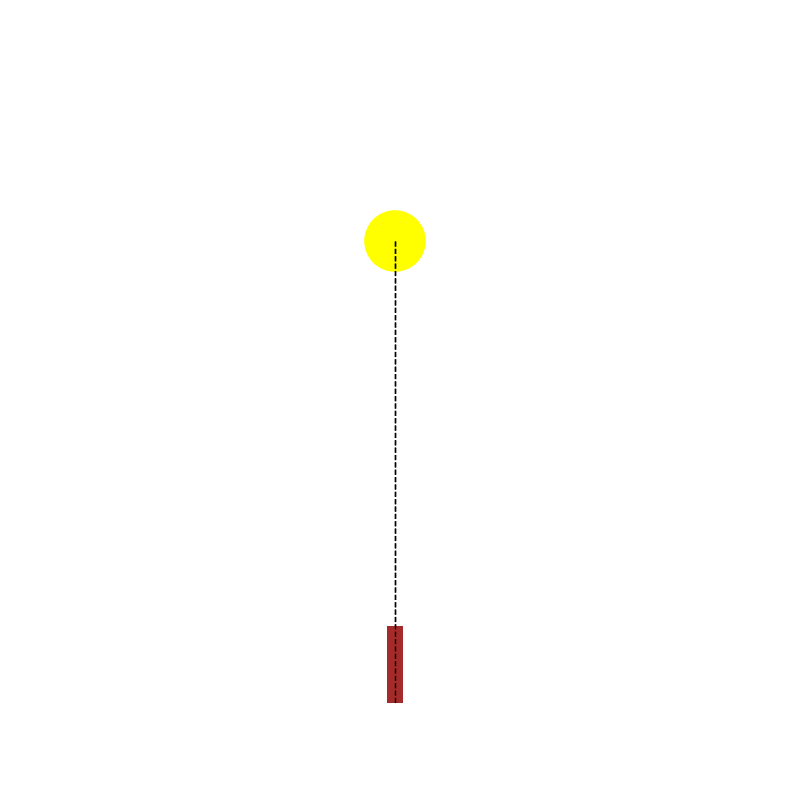

In [17]:
import matplotlib.pyplot as plt
import numpy as np

def create_sun_shadow_image(sun_height, pole_height, sun_distance, image_size=(500, 500)):
    # 创建一个白色背景的图像
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_xlim(0, image_size[0])
    ax.set_ylim(0, image_size[1])
    ax.set_aspect('equal')
    ax.axis('off')

    # 设置参数
    ground_level = 50
    pole_base_x = image_size[0] // 2
    pole_width = 10

    # 计算阴影长度
    shadow_length = pole_height * sun_distance / (sun_height - pole_height)

    # 绘制阴影（黑色矩形）
    ax.add_patch(plt.Rectangle((pole_base_x, ground_level - 10), shadow_length, 10, facecolor='black'))

    # 绘制杆（棕色矩形）
    ax.add_patch(plt.Rectangle((pole_base_x - pole_width/2, ground_level), pole_width, pole_height, facecolor='brown'))

    # 绘制太阳（黄色圆形）
    sun_x = pole_base_x - sun_distance
    sun_y = sun_height + ground_level
    sun_radius = 20
    ax.add_patch(plt.Circle((sun_x, sun_y), sun_radius, facecolor='yellow'))

    # 绘制虚线
    ax.plot([sun_x, pole_base_x], [sun_y, ground_level + pole_height], 'k--', linewidth=1)
    ax.plot([sun_x, pole_base_x + shadow_length], [sun_y, ground_level], 'k--', linewidth=1)

    # 添加标签
    # ax.text(sun_x - 30, sun_y + 30, fontsize=12)
    # ax.text(pole_base_x + shadow_length/2, ground_level - 30, fontsize=12)
    # ax.text(pole_base_x + pole_width, ground_level + pole_height // 2, fontsize=12)

    # 显示数值
    # ax.text(10, image_size[1] - 30, f'Sun Height: {sun_height}', fontsize=10)
    # ax.text(10, image_size[1] - 50, f'Pole Height: {pole_height}', fontsize=10)
    # ax.text(10, image_size[1] - 70, f'Sun Distance: {sun_distance}', fontsize=10)
    # ax.text(10, image_size[1] - 90, f'Shadow Length: {shadow_length:.2f}', fontsize=10)

    return fig

# 设置变量
sun_height = 300  # 太阳高度
pole_height = 50  # 杆子高度
sun_distance = 0 # 太阳离杆子的水平距离

# 生成并显示图片
fig = create_sun_shadow_image(sun_height, pole_height, sun_distance)
plt.show()

## 8

/tmp/ipykernel_2519312/2455219574.py:43: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  image = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')


Theoretical values: s1=64.00, s2=192.00, l1=96.00, l2=64.00
Detected values: s1=154.00, s2=232.00, l1=115.00, l2=154.00
Theoretical ratio: 4.5000
Detected ratio: 1.1250
Relative error: 75.00%


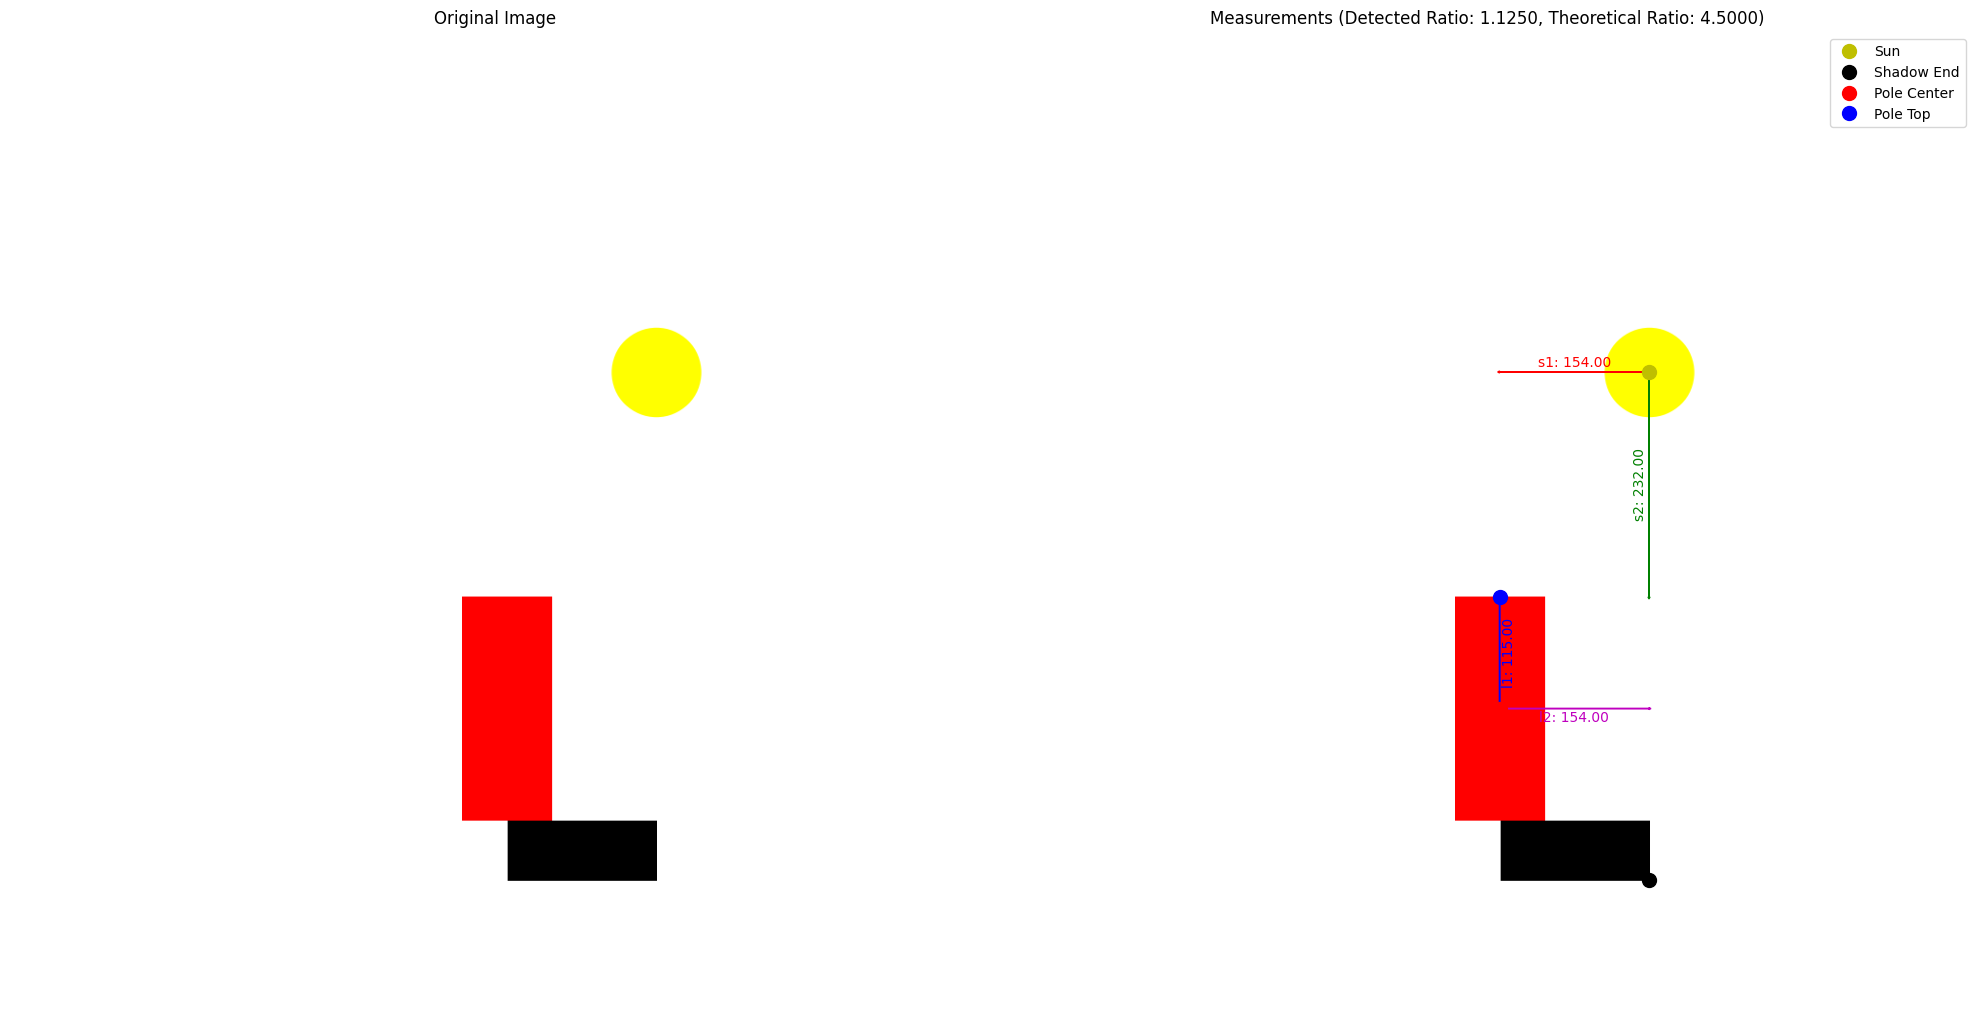

Analysis status: success
Details: Detected ratio: 1.1250, Theoretical ratio: 4.5000, Relative error: 75.00%


In [71]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg

def create_sun_shadow_image(pole_height, sun_distance, image_size=32, is_real=True):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_xlim(0, image_size)
    ax.set_ylim(0, image_size)
    ax.set_aspect('equal')
    ax.axis('off')

    ground_level = image_size * 0.1
    pole_base_x = image_size // 2
    pole_width = image_size * 0.12

    sun_height = np.clip(pole_height * 2, image_size * 0.3, image_size * 0.8)

    shadow_length = pole_height * abs(sun_distance) / (sun_height - pole_height)
    
    shadow_direction = 1 if sun_distance > 0 else -1

    ax.add_patch(plt.Rectangle((pole_base_x, ground_level - image_size * 0.08), 
                               shadow_length * shadow_direction, image_size * 0.08, facecolor='black'))

    ax.add_patch(plt.Rectangle((pole_base_x - pole_width/2, ground_level), 
                               pole_width, pole_height, facecolor='red'))

    sun_radius = image_size * 0.06
    sun_x = pole_base_x + sun_distance
    sun_y = sun_height + ground_level
    ax.add_patch(plt.Circle((sun_x, sun_y), sun_radius, facecolor='yellow'))

    # 计算理论值
    s1 = abs(sun_distance)
    s2 = sun_height
    l1 = pole_height
    l2 = shadow_length

    # 将图形转换为图像
    canvas = FigureCanvasAgg(fig)
    canvas.draw()
    image = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(canvas.get_width_height()[::-1] + (3,))
    plt.close(fig)

    return image, (s1, s2, l1, l2)

def calculate_center_and_end(mask, pole_center):
    y, x = np.nonzero(mask)
    if len(x) == 0 or len(y) == 0:
        return (0, 0), (0, 0)
    left, right = np.min(x), np.max(x)
    top, bottom = np.min(y), np.max(y)
    center_x = (left + right) // 2
    center_y = (top + bottom) // 2
    
    end_x = left if abs(left - pole_center[0]) > abs(right - pole_center[0]) else right
    end_y = bottom
    
    return (center_x, center_y), (end_x, end_y)

def analyze_single_image(image, theoretical_values):
    image_size = image.shape[0]
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    yellow_lower = np.array([20, 100, 100])
    yellow_upper = np.array([30, 255, 255])
    black_lower = np.array([0, 0, 0])
    black_upper = np.array([180, 255, 30])
    red_lower1 = np.array([0, 100, 100])
    red_upper1 = np.array([10, 255, 255])
    red_lower2 = np.array([160, 100, 100])
    red_upper2 = np.array([180, 255, 255])

    yellow_mask = cv2.inRange(hsv, yellow_lower, yellow_upper)
    black_mask = cv2.inRange(hsv, black_lower, black_upper)
    red_mask1 = cv2.inRange(hsv, red_lower1, red_upper1)
    red_mask2 = cv2.inRange(hsv, red_lower2, red_upper2)
    red_mask = cv2.bitwise_or(red_mask1, red_mask2)

    red_y, red_x = np.nonzero(red_mask)
    if len(red_x) == 0 or len(red_y) == 0:
        return "fail", None, "Failed to detect pole"
    red_cx = np.mean(red_x)
    red_cy = np.mean(red_y)
    red_top = np.min(red_y)
    
    (yellow_cx, yellow_cy), _ = calculate_center_and_end(yellow_mask, (red_cx, red_cy))
    (black_cx, black_cy), (shadow_end_x, shadow_end_y) = calculate_center_and_end(black_mask, (red_cx, red_cy))

    s1 = abs(yellow_cx - red_cx)
    s2 = abs(yellow_cy - red_top)
    l1 = red_cy - red_top
    l2 = abs(shadow_end_x - red_cx)

    ratio = (s2 * l1) / (s1 * l2) if s1 != 0 and l2 != 0 else 0

    # 比较理论值和检测值
    s1_theo, s2_theo, l1_theo, l2_theo = theoretical_values
    theo_ratio = (s2_theo * l1_theo) / (s1_theo * l2_theo)
    
    print(f"Theoretical values: s1={s1_theo:.2f}, s2={s2_theo:.2f}, l1={l1_theo:.2f}, l2={l2_theo:.2f}")
    print(f"Detected values: s1={s1:.2f}, s2={s2:.2f}, l1={l1:.2f}, l2={l2:.2f}")
    print(f"Theoretical ratio: {theo_ratio:.4f}")
    print(f"Detected ratio: {ratio:.4f}")
    print(f"Relative error: {abs(theo_ratio - ratio) / theo_ratio * 100:.2f}%")

    # 可视化结果
    plt.figure(figsize=(20, 10))
    
    plt.subplot(121)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(122)
    plt.imshow(image)
    plt.plot(yellow_cx, yellow_cy, 'yo', markersize=10, label='Sun')
    plt.plot(shadow_end_x, shadow_end_y, 'ko', markersize=10, label='Shadow End')
    plt.plot(red_cx, red_cy, 'ro', markersize=10, label='Pole Center')
    plt.plot(red_cx, red_top, 'bo', markersize=10, label='Pole Top')
    
    plt.arrow(yellow_cx, yellow_cy, red_cx - yellow_cx, 0, color='r', width=0.5, head_width=2, head_length=2)
    plt.text((yellow_cx + red_cx) / 2, yellow_cy - 2, f's1: {s1:.2f}', color='r', ha='center', va='bottom')
    
    plt.arrow(yellow_cx, yellow_cy, 0, red_top - yellow_cy, color='g', width=0.5, head_width=2, head_length=2)
    plt.text(yellow_cx - 2, (yellow_cy + red_top) / 2, f's2: {s2:.2f}', color='g', ha='right', va='center', rotation=90)
    
    plt.arrow(red_cx, red_cy, 0, red_top - red_cy, color='b', width=0.5, head_width=2, head_length=2)
    plt.text(red_cx + 2, (red_cy + red_top) / 2, f'l1: {l1:.2f}', color='b', ha='left', va='center', rotation=90)
    
    plt.arrow(red_cx, red_cy, shadow_end_x - red_cx, 0, color='m', width=0.5, head_width=2, head_length=2)
    plt.text((red_cx + shadow_end_x) / 2, red_cy + 2, f'l2: {l2:.2f}', color='m', ha='center', va='top')
    
    plt.title(f"Measurements (Detected Ratio: {ratio:.4f}, Theoretical Ratio: {theo_ratio:.4f})")
    plt.legend()
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    return "success", ratio, f"Detected ratio: {ratio:.4f}, Theoretical ratio: {theo_ratio:.4f}, Relative error: {abs(theo_ratio - ratio) / theo_ratio * 100:.2f}%"

# 主程序
image_size = 320  # 增加图像大小以提高精度
pole_height = image_size * 0.3
sun_distance = image_size * 0.2

image, theoretical_values = create_sun_shadow_image(pole_height, sun_distance, image_size)
status, ratio, details = analyze_single_image(image, theoretical_values)

print(f"Analysis status: {status}")
print(f"Details: {details}")

### Tense

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm

def create_sun_shadow_image(pole_height, sun_x, image_size=32, is_real=True):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_xlim(0, image_size)
    ax.set_ylim(0, image_size)
    ax.set_aspect('equal')
    ax.axis('off')

    ground_level = image_size * 0.1
    pole_base_x = image_size // 2
    pole_width = image_size * 0.12

    sun_height = np.clip(pole_height * 2, image_size * 0.3, image_size * 0.8)

    sun_distance = sun_x - pole_base_x
    shadow_length = pole_height * abs(sun_distance) / (sun_height - pole_height)
    
    # 根据是否真实调整阴影方向
    if is_real:
        shadow_direction = -1 if sun_distance > 0 else 1
    else:
        shadow_direction = 1 if sun_distance > 0 else -1

    ax.add_patch(plt.Rectangle((pole_base_x, ground_level - image_size * 0.08), 
                               shadow_length * shadow_direction, image_size * 0.08, facecolor='black'))

    ax.add_patch(plt.Rectangle((pole_base_x - pole_width/2, ground_level), 
                               pole_width, pole_height, facecolor='red'))

    sun_radius = image_size * 0.1
    sun_y = sun_height + ground_level
    ax.add_patch(plt.Circle((sun_x, sun_y), sun_radius, facecolor='yellow'))

    return fig

def generate_images(base_path, min_pole_height, max_pole_height, image_size=32, images_per_class=1000):
    os.makedirs(base_path, exist_ok=True)
    
    # 新的距离区间定义
    far_distances = [(0, 6), (26, 32)]
    near_distances = [(10, 16), (16, 22)]

    classes = [
        ('l', 'f', 's'), ('l', 'f', 'd'), ('l', 'n', 's'), ('l', 'n', 'd'),
        ('r', 'f', 's'), ('r', 'f', 'd'), ('r', 'n', 's'), ('r', 'n', 'd')
    ]

    for direction, distance, real in classes:
        folder_name = f"{direction}_{distance}_{real}"
        folder_path = os.path.join(base_path, folder_name)
        os.makedirs(folder_path, exist_ok=True)

        is_real = (real == 'd')
        
        if distance == 'f':
            distance_ranges = far_distances
        else:
            distance_ranges = near_distances

        for j in tqdm(range(images_per_class), desc=f"Generating images for {folder_name}"):
            # 随机选择一个距离区间
            if direction == 'l':
                distance_range = distance_ranges[0]  # 左侧使用第一个区间
            else:
                distance_range = distance_ranges[1]  # 右侧使用第二个区间
            
            sun_x = np.random.uniform(*distance_range)

            pole_height = np.random.uniform(min_pole_height, max_pole_height)
            fig = create_sun_shadow_image(pole_height, sun_x, image_size, is_real)
            
            image_path = os.path.join(folder_path, f"{j+1}.png")
            fig.savefig(image_path, bbox_inches='tight', pad_inches=0, dpi=100)
            plt.close(fig)

    print("Image generation complete.")

# 设置参数
base_path = "/cpfs01/user/hanyujin/causal-dm/synthetic_data_eight_v2"
image_size = 32
min_pole_height = image_size * 0.2
max_pole_height = image_size * 0.4

# 生成图片
generate_images(base_path, min_pole_height, max_pole_height, image_size)

Generating images for r_n_d: 100%|██████████| 1000/1000 [00:44<00:00, 22.67it/s]

Image generation complete.


## Shape and Color

In [6]:
import numpy as np
from PIL import Image, ImageDraw
import os

def create_image(size, distance, is_yellow_right, yellow_y, black_y, circle_radius):
    img = Image.new('RGB', (size, size), color='white')
    draw = ImageDraw.Draw(img)

    mid_x = size // 2

    if is_yellow_right:
        yellow_center_x = mid_x + distance
        black_center_x = mid_x - distance
    else:
        yellow_center_x = mid_x - distance
        black_center_x = mid_x + distance

    # 画黄色圆
    draw.ellipse([yellow_center_x - circle_radius, yellow_y - circle_radius, 
                  yellow_center_x + circle_radius, yellow_y + circle_radius], 
                 fill='yellow')

    # 画黑色圆
    draw.ellipse([black_center_x - circle_radius, black_y - circle_radius, 
                  black_center_x + circle_radius, black_y + circle_radius], 
                 fill='black')

    return img

def generate_dataset(output_dir, images_per_interval=1500):
    size = 32  # 改为32x32
    circle_radius = 4  # 减小圆的半径
    # 定义6个区间，调整距离以适应32x32的图片
    intervals = [
        ('interval_l3', 10, 12, False),
        ('interval_l2', 6, 8, False),
        ('interval_l1', 2, 4, False),
        ('interval_r1', 2, 4, True),
        ('interval_r2', 6, 8, True),
        ('interval_r3', 10, 12, True)
    ]

    for folder_name, min_dist, max_dist, is_yellow_right in intervals:
        interval_dir = f'{output_dir}/{folder_name}'
        if not os.path.exists(interval_dir):
            os.makedirs(interval_dir)

        for j in range(images_per_interval):
            # 随机选择圆距离中轴线的距离
            distance = np.random.uniform(min_dist, max_dist)
            
            # 随机选择黄色和黑色圆的y位置，确保黄色圆在上方
            yellow_y = np.random.uniform(circle_radius, size//2 - circle_radius)
            black_y = np.random.uniform(yellow_y + 2*circle_radius, size - circle_radius)

            img = create_image(size, distance, is_yellow_right, yellow_y, black_y, circle_radius)
            img.save(f'{interval_dir}/image_{j:04d}.png')

    print(f"Generated {images_per_interval * 6} images in total.")

# 生成数据集
generate_dataset('/cpfs01/user/hanyujin/causal-dm/circle_data')

Generated 9000 images in total.


## Size and Color

Gradient image saved as 'gradient_rwb.png'


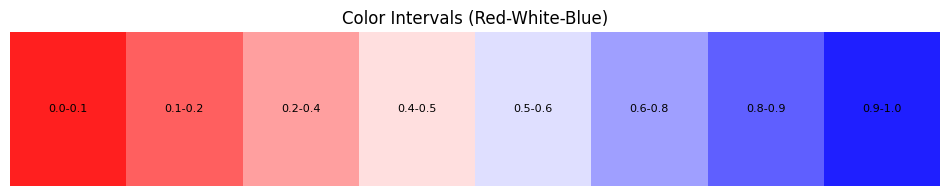

In [9]:
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

def get_color(value):
    """
    根据 0-1 之间的值返回对应的颜色
    0 对应纯红色 (255, 0, 0)
    0.5 对应白色 (255, 255, 255)
    1 对应纯蓝色 (0, 0, 255)
    """
    if value < 0.5:
        # 从红色到白色
        r = 255
        g = b = int(510 * value)
    else:
        # 从白色到蓝色
        r = g = int(510 * (1 - value))
        b = 255
    return (r, g, b)

def create_gradient_image(width, height):
    img = Image.new('RGB', (width, height))
    draw = ImageDraw.Draw(img)
    
    for x in range(width):
        color = get_color(x / (width - 1))
        draw.line([(x, 0), (x, height)], fill=color)
    
    return img

def show_color_intervals(num_intervals=8):
    fig, ax = plt.subplots(figsize=(12, 2))
    for i in range(num_intervals):
        start = i / num_intervals
        end = (i + 1) / num_intervals
        mid = (start + end) / 2
        color = get_color(mid)
        ax.add_patch(plt.Rectangle((start, 0), 1/num_intervals, 1, facecolor=tuple(c/255 for c in color)))
        ax.text(mid, 0.5, f'{start:.1f}-{end:.1f}', ha='center', va='center', fontsize=8)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')
    plt.title('Color Intervals (Red-White-Blue)')
    plt.show()

# 创建渐变图像
gradient_img = create_gradient_image(256, 50)
# gradient_img.save('gradient_rwb.png')
print("Gradient image saved as 'gradient_rwb.png'")

# 显示颜色区间
show_color_intervals()

# Compositional Probe

### Training

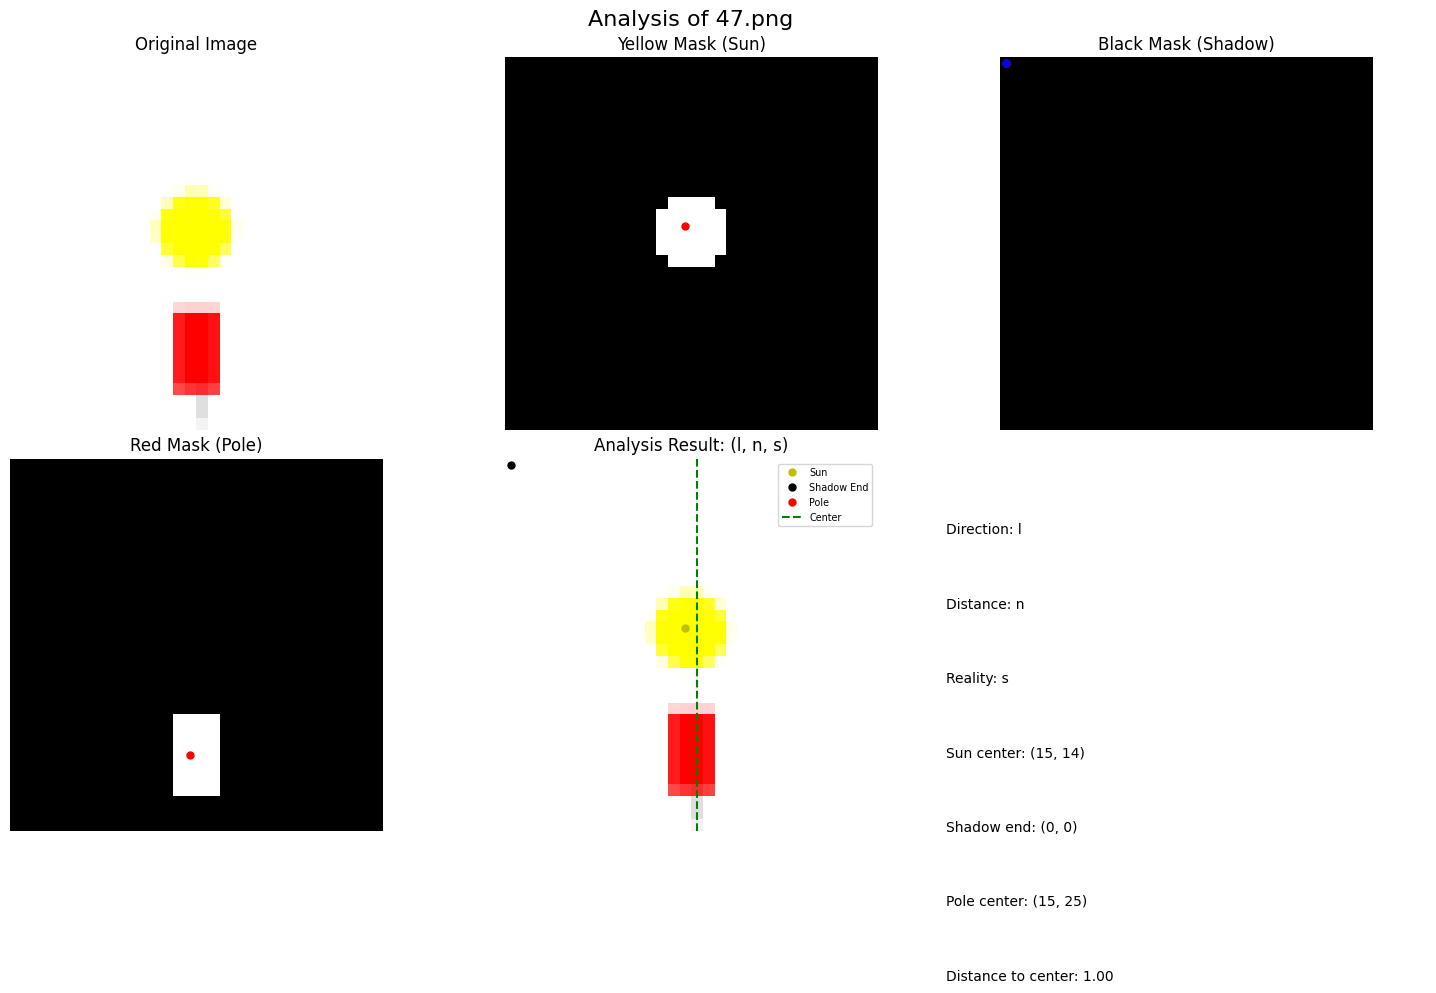

Analysis status: success
Label: ('l', 'n', 's')
Details: Sun center: (15, 14), Shadow end: (0, 0), Pole center: (15, 25), Distance to center: 1.00


In [39]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

def calculate_center_and_end(mask, pole_center):
    y, x = np.nonzero(mask)
    if len(x) == 0 or len(y) == 0:
        return (0, 0), (0, 0)
    left, right = np.min(x), np.max(x)
    top, bottom = np.min(y), np.max(y)
    center_x = (left + right) // 2
    center_y = (top + bottom) // 2
    
    # 阴影末端是远离杆子的一侧
    end_x = left if abs(left - pole_center[0]) > abs(right - pole_center[0]) else right
    end_y = bottom
    
    return (center_x, center_y), (end_x, end_y)

def analyze_and_visualize_image(image_path, target_size=32):
    # 读取图像
    img = cv2.imread(image_path)
    if img is None:
        return "fail", None, "Image could not be read"

    # 调整图像大小为 32x32
    img = cv2.resize(img, (target_size, target_size), interpolation=cv2.INTER_AREA)

    # 转换为RGB（用于显示）和HSV颜色空间
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # 定义颜色范围
    yellow_lower = np.array([20, 100, 100])
    yellow_upper = np.array([30, 255, 255])
    black_lower = np.array([0, 0, 0])
    black_upper = np.array([180, 100, 210])  
    red_lower1 = np.array([0, 100, 100])
    red_upper1 = np.array([10, 255, 255])
    red_lower2 = np.array([160, 100, 100])
    red_upper2 = np.array([180, 255, 255])

    # 创建掩码
    yellow_mask = cv2.inRange(hsv, yellow_lower, yellow_upper)
    black_mask = cv2.inRange(hsv, black_lower, black_upper)
    red_mask1 = cv2.inRange(hsv, red_lower1, red_upper1)
    red_mask2 = cv2.inRange(hsv, red_lower2, red_upper2)
    red_mask = cv2.bitwise_or(red_mask1, red_mask2)

    # 计算中心和末端
    (red_cx, red_cy), _ = calculate_center_and_end(red_mask, (0, 0))
    (yellow_cx, yellow_cy), _ = calculate_center_and_end(yellow_mask, (red_cx, red_cy))
    (black_cx, black_cy), (shadow_end_x, shadow_end_y) = calculate_center_and_end(black_mask, (red_cx, red_cy))

    # 确定方向、距离和真实性
    direction = 'l' if yellow_cx < target_size/2 else 'r'
    distance_to_center = abs(yellow_cx - target_size/2)
    if 0 <= distance_to_center <= 8:
        distance = 'n'
    elif 8 < distance_to_center <= 16:
        distance = 'f'
    else:
        distance = 'm'
    real = 'd' if (yellow_cx <= red_cx < shadow_end_x) or (shadow_end_x < red_cx < yellow_cx) else 's'
    if (shadow_end_x == yellow_cx):
        real = 's'

    # 可视化
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle(f"Analysis of {os.path.basename(image_path)}", fontsize=16)

    # 原始图像
    axs[0, 0].imshow(img_rgb)
    axs[0, 0].set_title("Original Image")
    axs[0, 0].axis('off')

    # 黄色掩码（太阳）
    axs[0, 1].imshow(yellow_mask, cmap='gray')
    axs[0, 1].set_title("Yellow Mask (Sun)")
    axs[0, 1].plot(yellow_cx, yellow_cy, 'ro', markersize=5)
    axs[0, 1].axis('off')

    # 黑色掩码（影子）
    axs[0, 2].imshow(black_mask, cmap='gray')
    axs[0, 2].set_title("Black Mask (Shadow)")
    axs[0, 2].plot(black_cx, black_cy, 'ro', markersize=5)
    axs[0, 2].plot(shadow_end_x, shadow_end_y, 'bo', markersize=5)
    axs[0, 2].axis('off')

    # 红色掩码（杆子）
    axs[1, 0].imshow(red_mask, cmap='gray')
    axs[1, 0].set_title("Red Mask (Pole)")
    axs[1, 0].plot(red_cx, red_cy, 'ro', markersize=5)
    axs[1, 0].axis('off')

    # 最终分析结果
    axs[1, 1].imshow(img_rgb)
    axs[1, 1].plot(yellow_cx, yellow_cy, 'yo', markersize=5, label='Sun')
    axs[1, 1].plot(shadow_end_x, shadow_end_y, 'ko', markersize=5, label='Shadow End')
    axs[1, 1].plot(red_cx, red_cy, 'ro', markersize=5, label='Pole')
    axs[1, 1].axvline(x=target_size/2, color='g', linestyle='--', label='Center')
    axs[1, 1].legend(loc='upper right', fontsize='x-small')
    axs[1, 1].set_title(f"Analysis Result: ({direction}, {distance}, {real})")
    axs[1, 1].axis('off')

    # 文字说明
    axs[1, 2].axis('off')
    axs[1, 2].text(0, 0.8, f"Direction: {direction}", fontsize=10)
    axs[1, 2].text(0, 0.6, f"Distance: {distance}", fontsize=10)
    axs[1, 2].text(0, 0.4, f"Reality: {real}", fontsize=10)
    axs[1, 2].text(0, 0.2, f"Sun center: ({yellow_cx}, {yellow_cy})", fontsize=10)
    axs[1, 2].text(0, 0, f"Shadow end: ({shadow_end_x}, {shadow_end_y})", fontsize=10)
    axs[1, 2].text(0, -0.2, f"Pole center: ({red_cx}, {red_cy})", fontsize=10)
    axs[1, 2].text(0, -0.4, f"Distance to center: {distance_to_center:.2f}", fontsize=10)

    plt.tight_layout()
    plt.show()

    return "success", (direction, distance, real), f"Sun center: ({yellow_cx}, {yellow_cy}), Shadow end: ({shadow_end_x}, {shadow_end_y}), Pole center: ({red_cx}, {red_cy}), Distance to center: {distance_to_center:.2f}"

# 使用示例
image_path = "/cpfs01/user/hanyujin/causal-dm/synthetic_data_eight_v2/l_n_d/47.png"
status, label, details = analyze_and_visualize_image(image_path)

print(f"Analysis status: {status}")
if status == "success":
    print(f"Label: {label}")
print(f"Details: {details}")

In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from collections import defaultdict
from tqdm import tqdm
import re

def calculate_center_and_end(mask, pole_center):
    y, x = np.nonzero(mask)
    if len(x) == 0 or len(y) == 0:
        return (0, 0), (0, 0)
    left, right = np.min(x), np.max(x)
    top, bottom = np.min(y), np.max(y)
    center_x = (left + right) // 2
    center_y = (top + bottom) // 2
    
    # 阴影末端是远离杆子的一侧
    end_x = left if abs(left - pole_center[0]) > abs(right - pole_center[0]) else right
    end_y = bottom
    
    return (center_x, center_y), (end_x, end_y)


def analyze_single_image(image_path, target_size=32):
    # 读取图像
    img = cv2.imread(image_path)
    if img is None:
        return "fail", None, "Image could not be read"

    # 调整图像大小为 32x32
    img = cv2.resize(img, (target_size, target_size), interpolation=cv2.INTER_AREA)

    # 转换为RGB（用于显示）和HSV颜色空间
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # 定义颜色范围
    yellow_lower = np.array([20, 100, 100])
    yellow_upper = np.array([30, 255, 255])
    black_lower = np.array([0, 0, 0])
    black_upper = np.array([180, 100, 120])  
    red_lower1 = np.array([0, 100, 100])
    red_upper1 = np.array([10, 255, 255])
    red_lower2 = np.array([160, 100, 100])
    red_upper2 = np.array([180, 255, 255])

    # 创建掩码
    yellow_mask = cv2.inRange(hsv, yellow_lower, yellow_upper)
    black_mask = cv2.inRange(hsv, black_lower, black_upper)
    red_mask1 = cv2.inRange(hsv, red_lower1, red_upper1)
    red_mask2 = cv2.inRange(hsv, red_lower2, red_upper2)
    red_mask = cv2.bitwise_or(red_mask1, red_mask2)

    # 计算中心和末端
    (red_cx, red_cy), _ = calculate_center_and_end(red_mask, (0, 0))
    (yellow_cx, yellow_cy), _ = calculate_center_and_end(yellow_mask, (red_cx, red_cy))
    (black_cx, black_cy), (shadow_end_x, shadow_end_y) = calculate_center_and_end(black_mask, (red_cx, red_cy))

    # 确定方向、距离和真实性
    direction = 'l' if yellow_cx < target_size/2 else 'r'
    # distance_to_center = abs(yellow_cx - target_size/2)
    # if 0 <= distance_to_center <= 8:
    #     distance = 'n'
    # elif 8 < distance_to_center <= 16:
    #     distance = 'f'
    # else:
    #     distance = 'm'
    real = 'd' if (yellow_cx <= red_cx < shadow_end_x) or (shadow_end_x < red_cx < yellow_cx) else 's'
    if (shadow_end_x == yellow_cx):
        real = 's'

    # 计算距离
    distance_to_center = abs(yellow_cx - target_size/2)
    near_distance = (0, 8)
    far_distance = (8.5, 16)
    # print('distance_to_center:',distance_to_center)
    if near_distance[0] <= distance_to_center <= near_distance[1]:
         distance = 'n' 
    elif far_distance[0] < distance_to_center <= far_distance[1]:
        distance = 'f'
    # else:
    #     distance = 'f'  # 中间距离
    # if far_distance[0] <= distance_to_center <= far_distance[1]:
    #      distance = 'f'
    # else: 
    #     distance = 'n'

    return "success", (direction, distance, real), f"Sun center: ({yellow_cx}, {yellow_cy}), Shadow end: ({shadow_end_x}, {shadow_end_y}), Pole center: ({red_cx}, {red_cy}), Distance to center: {distance_to_center:.2f}"

def analyze_folder(folder_path):
    results = defaultdict(list)
    total_count = 0
    fail_count = 0
    processed_files = []
    skipped_files = []

    for filename in tqdm(sorted(os.listdir(folder_path))):
        if filename.endswith(('.png', '.jpg', '.jpeg')) and re.search(r'\d+\.(?:png|jpg|jpeg)$', filename):
            total_count += 1
            image_path = os.path.join(folder_path, filename)
            status, label, details = analyze_single_image(image_path)
            
            if status == "fail":
                fail_count += 1
                results["fail"].append(filename)
                skipped_files.append((filename, details))
            else:
                results[label].append(filename)
                processed_files.append(filename)
        else:
            skipped_files.append((filename, "Does not match the expected format"))

    # 计算统计信息
    fail_rate = fail_count / total_count if total_count > 0 else 0
    label_percentages = {label: len(files) / total_count for label, files in results.items()} if total_count > 0 else {}

    return fail_rate, label_percentages, results, processed_files, skipped_files
# 使用示例
folder_path = "/cpfs01/user/hanyujin/causal-dm/synthetic_data_eight_v2/l_n_d"
fail_rate, label_percentages, results, processed_files, skipped_files = analyze_folder(folder_path)

print(f"Total files in folder: {len(os.listdir(folder_path))}")
print(f"Processed files: {len(processed_files)}")
print(f"Skipped files: {len(skipped_files)}")
print(f"Fail rate: {fail_rate:.2%}")
print("\nLabel percentages:")
for label, percentage in label_percentages.items():
    print(f"{label}: {percentage:.2%}")

print("\nNumber of images in each category:")
for label, files in results.items():
    print(f"{label}: {len(files)}")

# 保存失败率、标签百分比和每个类别的图片数量到文本文件
with open(os.path.join(folder_path, "analysis_results.txt"), "w") as f:
    f.write(f"Fail rate: {fail_rate:.2%}\n\n")
    
    f.write("Label percentages:\n")
    for label, percentage in label_percentages.items():
        f.write(f"{label}: {percentage:.2%}\n")
    f.write("\n")
    
    f.write("Number of images in each category:\n")
    for label, files in results.items():
        f.write(f"{label}: {len(files)}\n")

# 如果需要，可以将每个类别的文件ID保存到文件中
for label, files in results.items():
    with open(os.path.join(folder_path, f"{label}_files.txt"), "w") as f:
        for file in files:
            f.write(f"{file}\n")

print(f"\nAnalysis results have been saved to {os.path.join(folder_path, 'analysis_results.txt')}")

 10%|▉         | 93/961 [00:00<00:08, 104.74it/s]

100%|██████████| 961/961 [00:09<00:00, 105.98it/s]


Total files in folder: 961
Processed files: 957
Skipped files: 4
Fail rate: 0.00%

Label percentages:
('l', 'n', 'd'): 94.57%
('l', 'n', 's'): 5.43%

Number of images in each category:
('l', 'n', 'd'): 905
('l', 'n', 's'): 52

Analysis results have been saved to /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight_v2/l_n_d/analysis_results.txt


In [73]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import numpy as np

# 定义文件路径
image_directory = "/cpfs01/user/hanyujin/causal-dm/synthetic_data_eight_v2/r_n_"
a = ['l','n','d']
txt_file_path = image_directory + f"/('{a[0]}', '{a[1]}', '{a[2]}')_files.txt"
output_directory = os.path.join(image_directory, "poor_quality")

# 创建输出目录（如果不存在）
os.makedirs(output_directory, exist_ok=True)

# 读取文本文件
with open(txt_file_path, 'r') as file:
    image_names = file.read().splitlines()

# 计算子图布局
n_images = len(image_names)
cols = 10  # 每行显示10张图片
rows = (n_images + cols - 1) // cols  # 计算需要的行数

# 创建图形和子图
fig, axs = plt.subplots(rows, cols, figsize=(20, 4*rows))
fig.suptitle("Images from ('l', 'n', 's')_files.txt", fontsize=16)

# 展平axs数组，以便于索引
axs = axs.flatten()

# 读取、显示和保存图片
for i, image_name in enumerate(image_names):
    image_path = os.path.join(image_directory, image_name)
    if os.path.exists(image_path):
        # 读取图片
        img = Image.open(image_path)
        
        # 显示图片
        axs[i].imshow(img)
        axs[i].set_title(image_name, fontsize=8)
        axs[i].axis('off')
        
        # 保存图片
        output_path = os.path.join(output_directory, f"poor_quality_{i+1}_{a[0]}_{a[1]}_{a[2]}.png")
        # img.save(output_path)
        # os.remove(image_path)
    else:
        axs[i].text(0.5, 0.5, f"Image not found:\n{image_name}", 
                    ha='center', va='center', fontsize=8)
        axs[i].axis('off')

# 隐藏多余的子图
for j in range(i+1, len(axs)):
    axs[j].axis('off')

plt.tight_layout()
# plt.savefig(os.path.join(output_directory, f"poor_quality_summary_{a[0]}_{a[1]}_{a[2]}.png"), dpi=300, bbox_inches='tight')
plt.show()

print(f"图片已保存到: {output_directory}")

FileNotFoundError: [Errno 2] No such file or directory: "/cpfs01/user/hanyujin/causal-dm/synthetic_data_eight_v2/r_n_s/('l', 'n', 'd')_files.txt"

### Generation

9 11


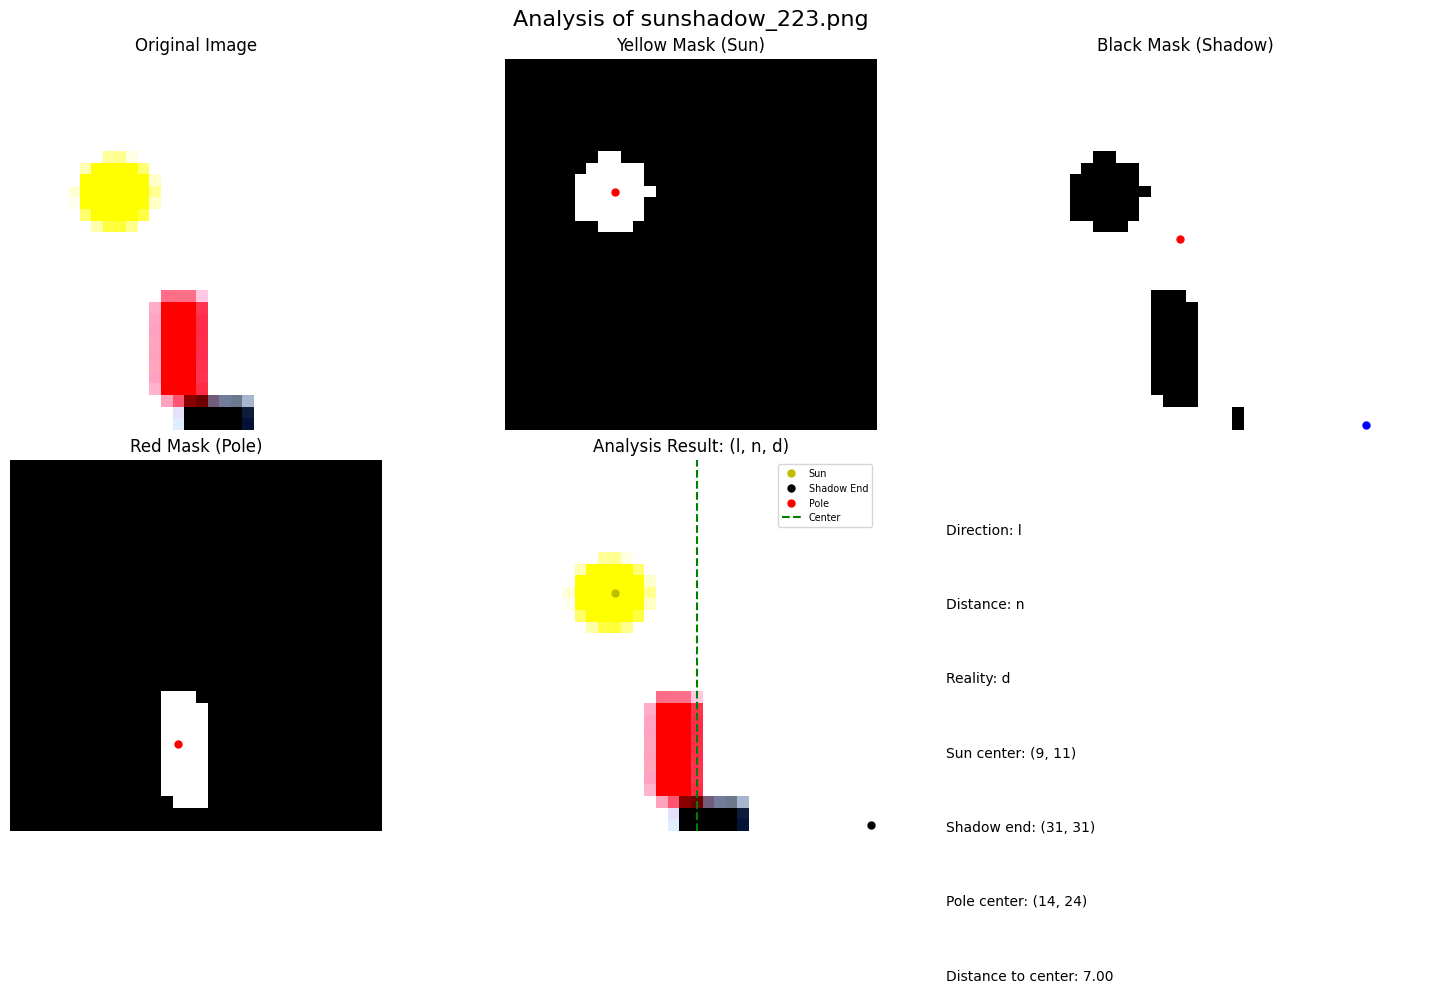

Analysis status: success
Label: ('l', 'n', 'd')
Details: Sun center: (9, 11), Shadow end: (31, 31), Pole center: (14, 24), Distance to center: 7.00


In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

def calculate_center_and_end(mask, pole_center):
    y, x = np.nonzero(mask)
    if len(x) == 0 or len(y) == 0:
        return (0, 0), (0, 0)
    left, right = np.min(x), np.max(x)
    top, bottom = np.min(y), np.max(y)
    center_x = (left + right) // 2
    center_y = (top + bottom) // 2
    
    # 阴影末端是远离杆子的一侧
    end_x = left if abs(left - pole_center[0]) > abs(right - pole_center[0]) else right
    end_y = bottom
    
    return (center_x, center_y), (end_x, end_y)

def analyze_and_visualize_image(image_path, target_size=32):
    # 读取图像
    img = cv2.imread(image_path)
    if img is None:
        return "fail", None, "Image could not be read"

    # 调整图像大小为 target_size x target_size
    img = cv2.resize(img, (target_size, target_size), interpolation=cv2.INTER_AREA)

    # 转换为RGB（用于显示）和HSV颜色空间
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # 定义颜色范围
    yellow_lower = np.array([20, 100, 100])
    yellow_upper = np.array([30, 255, 255])
    black_lower = np.array([0, 0, 0])
    black_upper = np.array([180, 100, 260])    # 大幅增加亮度上限，适度增加饱和度上限
    red_lower1 = np.array([0, 100, 100])
    red_upper1 = np.array([10, 255, 255])
    red_lower2 = np.array([160, 100, 100])
    red_upper2 = np.array([180, 255, 255])

    # 创建掩码
    yellow_mask = cv2.inRange(hsv, yellow_lower, yellow_upper)
    black_mask = cv2.inRange(hsv, black_lower, black_upper)
    red_mask1 = cv2.inRange(hsv, red_lower1, red_upper1)
    red_mask2 = cv2.inRange(hsv, red_lower2, red_upper2)
    red_mask = cv2.bitwise_or(red_mask1, red_mask2)

    # 计算中心和末端
    (red_cx, red_cy), _ = calculate_center_and_end(red_mask, (0, 0))
    (yellow_cx, yellow_cy), _ = calculate_center_and_end(yellow_mask, (red_cx, red_cy))
    (black_cx, black_cy), (shadow_end_x, shadow_end_y) = calculate_center_and_end(black_mask, (red_cx, red_cy))
    print(yellow_cx, yellow_cy)

    # 确定方向、距离和真实性
    direction = 'l' if yellow_cx < target_size/2 else 'r'
    distance_to_center = abs(yellow_cx - target_size/2)
    if 0 <= distance_to_center <= 8:
        distance = 'n'
    elif 8 < distance_to_center <= 16:
        distance = 'f'
    else:
        distance = 'm'
    real = 'd' if (yellow_cx <= red_cx < shadow_end_x) or (shadow_end_x < red_cx < yellow_cx) else 's'
    if (shadow_end_x == yellow_cx):
        real = 's'

    # 可视化
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle(f"Analysis of {os.path.basename(image_path)}", fontsize=16)

    # 原始图像
    axs[0, 0].imshow(img_rgb)
    axs[0, 0].set_title("Original Image")
    axs[0, 0].axis('off')

    # 黄色掩码（太阳）
    axs[0, 1].imshow(yellow_mask, cmap='gray')
    axs[0, 1].set_title("Yellow Mask (Sun)")
    axs[0, 1].plot(yellow_cx, yellow_cy, 'ro', markersize=5)
    axs[0, 1].axis('off')

    # 黑色掩码（影子）
    axs[0, 2].imshow(black_mask, cmap='gray')
    axs[0, 2].set_title("Black Mask (Shadow)")
    axs[0, 2].plot(black_cx, black_cy, 'ro', markersize=5)
    axs[0, 2].plot(shadow_end_x, shadow_end_y, 'bo', markersize=5)
    axs[0, 2].axis('off')

    # 红色掩码（杆子）
    axs[1, 0].imshow(red_mask, cmap='gray')
    axs[1, 0].set_title("Red Mask (Pole)")
    axs[1, 0].plot(red_cx, red_cy, 'ro', markersize=5)
    axs[1, 0].axis('off')

    # 最终分析结果
    axs[1, 1].imshow(img_rgb)
    axs[1, 1].plot(yellow_cx, yellow_cy, 'yo', markersize=5, label='Sun')
    axs[1, 1].plot(shadow_end_x, shadow_end_y, 'ko', markersize=5, label='Shadow End')
    axs[1, 1].plot(red_cx, red_cy, 'ro', markersize=5, label='Pole')
    axs[1, 1].axvline(x=target_size/2, color='g', linestyle='--', label='Center')
    axs[1, 1].legend(loc='upper right', fontsize='x-small')
    axs[1, 1].set_title(f"Analysis Result: ({direction}, {distance}, {real})")
    axs[1, 1].axis('off')

    # 文字说明
    axs[1, 2].axis('off')
    axs[1, 2].text(0, 0.8, f"Direction: {direction}", fontsize=10)
    axs[1, 2].text(0, 0.6, f"Distance: {distance}", fontsize=10)
    axs[1, 2].text(0, 0.4, f"Reality: {real}", fontsize=10)
    axs[1, 2].text(0, 0.2, f"Sun center: ({yellow_cx}, {yellow_cy})", fontsize=10)
    axs[1, 2].text(0, 0, f"Shadow end: ({shadow_end_x}, {shadow_end_y})", fontsize=10)
    axs[1, 2].text(0, -0.2, f"Pole center: ({red_cx}, {red_cy})", fontsize=10)
    axs[1, 2].text(0, -0.4, f"Distance to center: {distance_to_center:.2f}", fontsize=10)

    plt.tight_layout()
    plt.show()

    return "success", (direction, distance, real), f"Sun center: ({yellow_cx}, {yellow_cy}), Shadow end: ({shadow_end_x}, {shadow_end_y}), Pole center: ({red_cx}, {red_cy}), Distance to center: {distance_to_center:.2f}"

# 使用示例
image_path = "/cpfs01/user/hanyujin/causal-dm/results/sunshadoweight_lfd_lns_lnd_rnd_v2/vis/1731248020.441068/sunshadow_223.png"
status, label, details = analyze_and_visualize_image(image_path, target_size=32)

print(f"Analysis status: {status}")
if status == "success":
    print(f"Label: {label}")
print(f"Details: {details}")

In [30]:
import cv2
import numpy as np
import os
from collections import defaultdict
from tqdm import tqdm
import re

def calculate_center_and_end(mask, pole_center):
    y, x = np.nonzero(mask)
    if len(x) == 0 or len(y) == 0:
        return (0, 0), (0, 0)
    left, right = np.min(x), np.max(x)
    top, bottom = np.min(y), np.max(y)
    center_x = (left + right) // 2
    center_y = (top + bottom) // 2
    
    # 阴影末端是远离杆子的一侧
    end_x = left if abs(left - pole_center[0]) > abs(right - pole_center[0]) else right
    end_y = bottom
    
    return (center_x, center_y), (end_x, end_y)

def analyze_single_image(image_path, image_size=32):
    # 读取图像
    img = cv2.imread(image_path)
    if img is None:
        return "fail", None, "Image could not be read"

    # 转换为RGB（用于显示）和HSV颜色空间
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # 定义颜色范围
    yellow_lower = np.array([20, 100, 100])
    yellow_upper = np.array([30, 255, 255])
    black_lower = np.array([0, 0, 0])
    black_upper = np.array([180, 255, 60])
    red_lower1 = np.array([0, 100, 100])
    red_upper1 = np.array([10, 255, 255])
    red_lower2 = np.array([160, 100, 100])
    red_upper2 = np.array([180, 255, 255])

    # 创建掩码
    yellow_mask = cv2.inRange(hsv, yellow_lower, yellow_upper)
    black_mask = cv2.inRange(hsv, black_lower, black_upper)
    red_mask1 = cv2.inRange(hsv, red_lower1, red_upper1)
    red_mask2 = cv2.inRange(hsv, red_lower2, red_upper2)
    red_mask = cv2.bitwise_or(red_mask1, red_mask2)

    # 首先计算杆子的中心
    (red_cx, red_cy), _ = calculate_center_and_end(red_mask, (0, 0))  # 杆子不需要末端
    
    # 然后计算太阳和阴影的中心和末端
    (yellow_cx, yellow_cy), _ = calculate_center_and_end(yellow_mask, (red_cx, red_cy))
    (black_cx, black_cy), (shadow_end_x, shadow_end_y) = calculate_center_and_end(black_mask, (red_cx, red_cy))

    # 如果任何计算结果为0，可能表示检测失败
    if yellow_cx == 0 or yellow_cy == 0 or shadow_end_x == 0 or shadow_end_y == 0 or red_cx == 0 and red_cy == 0:
        return "fail", None, f"Failed to calculate centers or ends accurately. Yellow: ({yellow_cx}, {yellow_cy}), Shadow end: ({shadow_end_x}, {shadow_end_y}), Red: ({red_cx}, {red_cy})"

    # 确定方向
    direction = 'l' if yellow_cx < image_size/2 else 'r'

    # 确定真实性（'s' 表示同侧，'d' 表示异侧）
    if (yellow_cx <= red_cx <= shadow_end_x) or (shadow_end_x <= red_cx <= yellow_cx):
        real = 'd'  # 杆子在太阳和影子之间，表示它们在不同侧
    else:
        real = 's'  # 太阳和影子在杆子的同一侧

    # 计算距离
    distance_to_center = abs(yellow_cx - image_size/2)
    near_distance = (0, 4)
    far_distance = (10, 16)
    if near_distance[0] <= distance_to_center <= near_distance[1]:
         distance = 'n' 
    elif far_distance[0] < distance_to_center <= far_distance[1]:
        distance = 'f' 
    # else:
    #     distance = 'm'  # a添加中间距离的情况

    return "success", (direction, distance, real), f"Sun center: ({yellow_cx}, {yellow_cy}), Shadow end: ({shadow_end_x}, {shadow_end_y}), Pole center: ({red_cx}, {red_cy}), Distance to center: {distance_to_center:.2f}"

def analyze_folder(folder_path):
    results = defaultdict(list)
    total_count = 0
    fail_count = 0
    processed_files = []
    skipped_files = []

    for filename in tqdm(sorted(os.listdir(folder_path))):
        if filename.endswith('.png'):
            total_count += 1
            image_path = os.path.join(folder_path, filename)
            try:
                status, label, _ = analyze_single_image(image_path)
                
                if status == "fail":
                    fail_count += 1
                    results["fail"].append(filename)
                else:
                    results[label].append(filename)
                
                processed_files.append(filename)
            except Exception as e:
                skipped_files.append((filename, str(e)))
        else:
            skipped_files.append((filename, "Does not match the expected format"))

    # 计算统计信息
    fail_rate = fail_count / total_count if total_count > 0 else 0
    label_percentages = {label: len(files) / total_count for label, files in results.items()} if total_count > 0 else {}

    return fail_rate, label_percentages, results, processed_files, skipped_files

# 使用示例
folder_path = "/cpfs01/user/hanyujin/causal-dm/results/sunshadoweight_lfd_lfs_lnd_lns_v2/vis/1733229172.4379218"
fail_rate, label_percentages, results, processed_files, skipped_files = analyze_folder(folder_path)

print(f"Total files in folder: {len(os.listdir(folder_path))}")
print(f"Processed files: {len(processed_files)}")
print(f"Skipped files: {len(skipped_files)}")
print(f"Fail rate: {fail_rate:.2%}")

# 打印被跳过的文件及原因
print("\nSkipped files:")
for filename, reason in skipped_files[:10]:  # 只打印前10个，避免输出过多
    print(f"{filename}: {reason}")

print("\nLabel percentages:")
for label, percentage in label_percentages.items():
    print(f"{label}: {percentage:.2%}")

print("\nNumber of images in each category:")
for label, files in results.items():
    print(f"{label}: {len(files)}")

# 保存失败率、标签百分比和每个类别的图片数量到文本文件
with open(os.path.join(folder_path, "analysis_results.txt"), "w") as f:
    f.write(f"Fail rate: {fail_rate:.2%}\n\n")
    
    f.write("Label percentages:\n")
    for label, percentage in label_percentages.items():
        f.write(f"{label}: {percentage:.2%}\n")
    f.write("\n")
    
    f.write("Number of images in each category:\n")
    for label, files in results.items():
        f.write(f"{label}: {len(files)}\n")

# 如果需要，可以将每个类别的文件ID保存到文件中
for label, files in results.items():
    with open(os.path.join(folder_path, f"{label}_files.txt"), "w") as f:
        for file in files:
            f.write(f"{file}\n")

print(f"\nAnalysis results have been saved to {os.path.join(folder_path, 'analysis_results.txt')}")

100%|██████████| 3009/3009 [00:02<00:00, 1106.37it/s]


Total files in folder: 3009
Processed files: 2507
Skipped files: 502
Fail rate: 21.03%

Skipped files:
('l', 'f', 'd')_files.txt: Does not match the expected format
('l', 'f', 's')_files.txt: Does not match the expected format
('l', 'n', 'd')_files.txt: Does not match the expected format
('l', 'n', 's')_files.txt: Does not match the expected format
('r', 'n', 'd')_files.txt: Does not match the expected format
('r', 'n', 's')_files.txt: Does not match the expected format
analysis_results.txt: Does not match the expected format
fail_files.txt: Does not match the expected format
sunshadowweight_10.png: cannot access local variable 'distance' where it is not associated with a value
sunshadowweight_1001.png: cannot access local variable 'distance' where it is not associated with a value

Label percentages:
fail: 21.03%
('l', 'f', 's'): 20.83%
('l', 'n', 's'): 5.93%
('l', 'f', 'd'): 28.86%
('l', 'n', 'd'): 6.56%
('r', 'n', 'd'): 0.27%
('r', 'n', 's'): 0.07%

Number of images in each category

In [15]:
import os
import shutil

# 源目录和目标目录
src_dir = "/cpfs01/user/hanyujin/causal-dm/results/sunshadoweight_rnd_v2/vis/1731421699.3733249"
dst_dir = "/cpfs01/user/hanyujin/causal-dm/results/sunshadoweight_rnd_v2/vis/1731421685.0237918"

# 确保目标目录存在
os.makedirs(dst_dir, exist_ok=True)

# 遍历源目录中的所有文件
for filename in os.listdir(src_dir):
    if filename.startswith("sunshadow_") and filename.endswith(".png"):
        # 提取文件名中的数字
        number = int(filename.split("_")[1].split(".")[0])
        
        # 增加 2000
        new_number = number +  3000
        
        # 创建新的文件名
        new_filename = f"sunshadow_{new_number}.png"
        
        # 构建完整的源文件路径和目标文件路径
        src_path = os.path.join(src_dir, filename)
        dst_path = os.path.join(dst_dir, new_filename)
        
        # 移动并重命名文件
        shutil.move(src_path, dst_path)
        print(f"Moved and renamed: {filename} -> {new_filename}")

print("All files have been moved and renamed.")

Moved and renamed: sunshadow_1963.png -> sunshadow_4963.png
Moved and renamed: sunshadow_2639.png -> sunshadow_5639.png
Moved and renamed: sunshadow_2202.png -> sunshadow_5202.png
Moved and renamed: sunshadow_2899.png -> sunshadow_5899.png
Moved and renamed: sunshadow_1682.png -> sunshadow_4682.png
Moved and renamed: sunshadow_1371.png -> sunshadow_4371.png
Moved and renamed: sunshadow_672.png -> sunshadow_3672.png
Moved and renamed: sunshadow_1602.png -> sunshadow_4602.png
Moved and renamed: sunshadow_2664.png -> sunshadow_5664.png
Moved and renamed: sunshadow_1741.png -> sunshadow_4741.png
Moved and renamed: sunshadow_1895.png -> sunshadow_4895.png
Moved and renamed: sunshadow_751.png -> sunshadow_3751.png
Moved and renamed: sunshadow_2690.png -> sunshadow_5690.png
Moved and renamed: sunshadow_657.png -> sunshadow_3657.png
Moved and renamed: sunshadow_2032.png -> sunshadow_5032.png
Moved and renamed: sunshadow_1110.png -> sunshadow_4110.png
Moved and renamed: sunshadow_64.png -> suns

Moved and renamed: sunshadow_633.png -> sunshadow_3633.png
Moved and renamed: sunshadow_548.png -> sunshadow_3548.png
Moved and renamed: sunshadow_1784.png -> sunshadow_4784.png
Moved and renamed: sunshadow_486.png -> sunshadow_3486.png
Moved and renamed: sunshadow_533.png -> sunshadow_3533.png
Moved and renamed: sunshadow_2373.png -> sunshadow_5373.png
Moved and renamed: sunshadow_1488.png -> sunshadow_4488.png
Moved and renamed: sunshadow_553.png -> sunshadow_3553.png
Moved and renamed: sunshadow_955.png -> sunshadow_3955.png
Moved and renamed: sunshadow_1322.png -> sunshadow_4322.png
Moved and renamed: sunshadow_1109.png -> sunshadow_4109.png
Moved and renamed: sunshadow_27.png -> sunshadow_3027.png
Moved and renamed: sunshadow_2837.png -> sunshadow_5837.png
Moved and renamed: sunshadow_2604.png -> sunshadow_5604.png
Moved and renamed: sunshadow_477.png -> sunshadow_3477.png
Moved and renamed: sunshadow_1074.png -> sunshadow_4074.png
Moved and renamed: sunshadow_946.png -> sunshadow

### Similarity

In [4]:
import os
import torch
from PIL import Image
from torchvision.transforms import Resize, CenterCrop, ToTensor, Normalize
from tqdm import tqdm
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 使用完整的包名导入 CLIP
import clip

# 设置路径
root_dir = '/cpfs01/user/hanyujin/causal-dm/synthetic_data_eight'

# 加载CLIP模型
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

100%|████████████████████████████████████████| 338M/338M [10:06<00:00, 583kiB/s]
Processing l_n_d:  20%|██        | 205/1000 [00:06<00:29, 27.28it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/111.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/333.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/555.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  21%|██        | 208/1000 [00:07<00:35, 22.54it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/777.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/174.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/396.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/711.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  21%|██▏       | 214/1000 [00:07<00:46, 16.78it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/933.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/880.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/330.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/552.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  22%|██▏       | 217/1000 [00:07<00:56, 13.83it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/774.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/171.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/393.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/930.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/818.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  22%|██▏       | 223/1000 [00:08<00:46, 16.88it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/771.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/659.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/390.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/109.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/278.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  23%|██▎       | 229/1000 [00:08<00:41, 18.76it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/815.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/709.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/656.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/878.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/106.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  23%|██▎       | 232/1000 [00:08<00:42, 17.98it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/328.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/275.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/497.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  23%|██▎       | 234/1000 [00:08<00:47, 16.04it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/812.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/169.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/706.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  24%|██▍       | 238/1000 [00:09<00:50, 15.20it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/653.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/875.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/72.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  24%|██▍       | 240/1000 [00:09<00:48, 15.52it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/103.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/325.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/547.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/272.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  24%|██▍       | 243/1000 [00:09<00:46, 16.41it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/494.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  24%|██▍       | 245/1000 [00:09<01:04, 11.72it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/166.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/703.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/650.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/872.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  25%|██▌       | 250/1000 [00:10<00:55, 13.43it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/52.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/85.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/100.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  25%|██▌       | 252/1000 [00:10<00:56, 13.21it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/322.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/544.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/491.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  25%|██▌       | 254/1000 [00:10<00:58, 12.84it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/36.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/163.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  26%|██▌       | 256/1000 [00:10<01:02, 11.82it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/385.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  26%|██▌       | 261/1000 [00:11<00:58, 12.70it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/700.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/979.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/541.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/429.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/49.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  26%|██▋       | 263/1000 [00:11<00:54, 13.64it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/160.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/382.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/807.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/976.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  27%|██▋       | 268/1000 [00:11<00:48, 15.06it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/426.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/648.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/267.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/489.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  27%|██▋       | 273/1000 [00:11<00:54, 13.41it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/804.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/973.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/423.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/645.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/867.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/317.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  28%|██▊       | 279/1000 [00:12<00:53, 13.58it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/264.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/486.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/801.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/970.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/158.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  28%|██▊       | 283/1000 [00:12<00:56, 12.72it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/420.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/642.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/864.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/314.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  28%|██▊       | 285/1000 [00:13<01:11,  9.96it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/261.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/483.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  29%|██▊       | 287/1000 [00:13<01:14,  9.55it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/908.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  29%|██▉       | 289/1000 [00:13<01:22,  8.65it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/155.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/861.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/749.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/311.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  29%|██▉       | 292/1000 [00:13<01:05, 10.89it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/480.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/905.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  29%|██▉       | 294/1000 [00:13<01:09, 10.18it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/152.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/746.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  30%|██▉       | 296/1000 [00:14<01:12,  9.67it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/968.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/418.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  30%|███       | 301/1000 [00:14<01:05, 10.63it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/587.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/902.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/259.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/743.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/965.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  31%|███       | 307/1000 [00:14<00:46, 14.76it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/415.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/637.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/20.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/584.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/53.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  31%|███       | 309/1000 [00:15<00:48, 14.24it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/256.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/478.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/740.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  31%|███▏      | 313/1000 [00:15<00:51, 13.24it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/962.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/412.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/634.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  32%|███▏      | 315/1000 [00:15<00:52, 13.08it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/581.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/33.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/66.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  32%|███▏      | 319/1000 [00:15<00:53, 12.68it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/99.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/253.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/475.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  32%|███▏      | 322/1000 [00:16<00:46, 14.46it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/17.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/631.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/519.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/250.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  32%|███▎      | 325/1000 [00:16<00:43, 15.50it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/472.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/516.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/738.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  33%|███▎      | 329/1000 [00:16<00:48, 13.97it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/357.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/579.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/198.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  33%|███▎      | 331/1000 [00:16<00:48, 13.67it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/513.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/735.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/957.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  33%|███▎      | 333/1000 [00:16<00:50, 13.30it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/407.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  34%|███▍      | 338/1000 [00:17<00:47, 14.02it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/354.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/576.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/798.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/248.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/195.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  34%|███▍      | 340/1000 [00:17<00:46, 14.12it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/510.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/732.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/954.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/404.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  34%|███▍      | 345/1000 [00:17<00:39, 16.74it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/351.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/573.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/795.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/245.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/192.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  35%|███▌      | 350/1000 [00:17<00:39, 16.31it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/951.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/401.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/570.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  35%|███▌      | 352/1000 [00:18<00:42, 15.27it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/792.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/242.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/508.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  36%|███▌      | 356/1000 [00:18<00:46, 13.85it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/6.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/677.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/899.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  36%|███▌      | 358/1000 [00:18<00:47, 13.52it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/127.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/349.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/50.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  36%|███▌      | 362/1000 [00:18<00:49, 12.97it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/83.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/505.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/727.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  36%|███▋      | 364/1000 [00:19<01:02, 10.19it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/949.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/674.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/896.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/124.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  37%|███▋      | 370/1000 [00:19<00:43, 14.38it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/346.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/568.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/34.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/187.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  37%|███▋      | 372/1000 [00:19<00:41, 15.00it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/502.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/724.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/946.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/96.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  38%|███▊      | 378/1000 [00:19<00:36, 17.19it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/671.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/893.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/121.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/343.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  38%|███▊      | 383/1000 [00:20<00:42, 14.53it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/565.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/14.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/47.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/184.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/721.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  39%|███▊      | 386/1000 [00:20<00:37, 16.32it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/943.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/890.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/340.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/562.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  39%|███▉      | 391/1000 [00:20<00:34, 17.49it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/181.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/940.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/828.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/447.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/669.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  40%|███▉      | 396/1000 [00:21<00:33, 18.13it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/119.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/288.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/825.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/719.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  40%|███▉      | 398/1000 [00:21<00:32, 18.51it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/444.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/666.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  40%|████      | 403/1000 [00:21<00:39, 15.26it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/888.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/116.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/338.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/285.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/822.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  40%|████      | 405/1000 [00:21<00:37, 15.93it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/179.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/716.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/663.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/885.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  41%|████      | 410/1000 [00:21<00:39, 14.86it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/113.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/335.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/557.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  41%|████      | 412/1000 [00:22<00:41, 14.20it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/282.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/176.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/713.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  42%|████▏     | 416/1000 [00:22<00:40, 14.32it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/660.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/882.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/110.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/332.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  42%|████▏     | 421/1000 [00:22<00:36, 15.91it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/554.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/173.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/710.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/989.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  42%|████▎     | 425/1000 [00:22<00:35, 16.41it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/551.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/439.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/80.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/170.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/817.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  43%|████▎     | 429/1000 [00:23<00:32, 17.38it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/986.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/31.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/64.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/436.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  43%|████▎     | 433/1000 [00:23<00:34, 16.48it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/658.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/108.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/277.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/499.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  44%|████▎     | 437/1000 [00:23<00:32, 17.36it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/15.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/814.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/983.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/1.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  44%|████▍     | 441/1000 [00:23<00:36, 15.17it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/77.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/433.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/655.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/877.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  44%|████▍     | 444/1000 [00:24<00:33, 16.60it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/105.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/327.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/274.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  45%|████▍     | 448/1000 [00:24<00:37, 14.58it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/496.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/28.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/811.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  45%|████▌     | 450/1000 [00:24<00:38, 14.18it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/980.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/430.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  46%|████▌     | 455/1000 [00:24<00:39, 13.65it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/652.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/874.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/102.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/324.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/271.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  46%|████▌     | 457/1000 [00:25<00:40, 13.52it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/493.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/918.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  46%|████▌     | 462/1000 [00:25<00:39, 13.52it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/871.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/759.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/321.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/490.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/209.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/915.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  46%|████▋     | 464/1000 [00:25<00:59,  9.02it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/809.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  47%|████▋     | 468/1000 [00:26<00:56,  9.39it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/756.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/978.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/206.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/428.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  47%|████▋     | 470/1000 [00:26<00:52, 10.18it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/597.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/912.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/269.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  47%|████▋     | 474/1000 [00:26<00:47, 11.14it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/806.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/753.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/975.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  48%|████▊     | 476/1000 [00:27<00:44, 11.74it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/203.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/425.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/647.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  48%|████▊     | 480/1000 [00:27<00:39, 13.04it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/594.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/266.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/488.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/803.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/750.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  48%|████▊     | 485/1000 [00:27<00:32, 15.63it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/972.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/200.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/422.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  49%|████▊     | 487/1000 [00:27<00:34, 14.66it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/644.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/591.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/263.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/485.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  49%|████▉     | 492/1000 [00:28<00:33, 15.20it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/800.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/81.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/641.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  49%|████▉     | 494/1000 [00:28<00:36, 13.98it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/529.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/260.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/482.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  50%|████▉     | 498/1000 [00:28<00:37, 13.21it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/907.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/61.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/94.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  50%|█████     | 500/1000 [00:28<00:39, 12.73it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/526.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/748.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/12.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  50%|█████     | 504/1000 [00:29<00:38, 12.72it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/45.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/367.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/589.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  51%|█████     | 506/1000 [00:29<00:39, 12.51it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/904.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/523.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/745.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  51%|█████     | 510/1000 [00:29<00:38, 12.88it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/967.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/58.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/417.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  51%|█████     | 512/1000 [00:29<00:38, 12.81it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/364.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/586.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  51%|█████▏    | 514/1000 [00:29<00:47, 10.31it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/901.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/258.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/520.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  52%|█████▏    | 516/1000 [00:30<00:45, 10.62it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/742.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/964.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  52%|█████▏    | 518/1000 [00:30<00:49,  9.67it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/414.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/361.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  52%|█████▏    | 522/1000 [00:30<00:46, 10.17it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/583.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/255.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/961.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  52%|█████▏    | 524/1000 [00:30<00:43, 10.85it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/849.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/411.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/580.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  53%|█████▎    | 528/1000 [00:31<00:39, 11.85it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/252.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/846.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/518.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  53%|█████▎    | 530/1000 [00:31<00:40, 11.70it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/687.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/137.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/359.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  53%|█████▎    | 534/1000 [00:31<00:45, 10.32it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/843.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/515.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/737.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  54%|█████▎    | 536/1000 [00:32<00:44, 10.54it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/684.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/134.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/356.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  54%|█████▍    | 540/1000 [00:32<00:39, 11.54it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/578.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/840.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/197.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  55%|█████▍    | 545/1000 [00:32<00:29, 15.53it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/512.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/734.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/681.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/131.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/353.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  55%|█████▍    | 548/1000 [00:32<00:31, 14.46it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/575.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/194.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/731.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  55%|█████▌    | 553/1000 [00:33<00:33, 13.48it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/62.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/350.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/572.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/191.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/950.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  56%|█████▌    | 555/1000 [00:33<00:32, 13.87it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/838.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/42.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/75.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/457.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  56%|█████▌    | 561/1000 [00:33<00:26, 16.85it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/679.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/26.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/129.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/298.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  56%|█████▋    | 565/1000 [00:33<00:26, 16.60it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/835.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/507.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/729.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/454.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  57%|█████▋    | 567/1000 [00:34<00:26, 16.43it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/676.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/898.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/39.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  57%|█████▋    | 569/1000 [00:34<00:33, 13.01it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/126.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/348.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  57%|█████▋    | 571/1000 [00:34<00:38, 11.28it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/295.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/832.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  57%|█████▋    | 573/1000 [00:34<00:41, 10.30it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/189.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  57%|█████▊    | 575/1000 [00:35<00:48,  8.77it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/504.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/726.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/451.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/673.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  58%|█████▊    | 581/1000 [00:35<00:33, 12.46it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/895.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/123.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/345.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/292.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  58%|█████▊    | 583/1000 [00:35<00:31, 13.12it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/186.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/501.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/723.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  58%|█████▊    | 585/1000 [00:35<00:36, 11.44it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/670.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/892.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  59%|█████▊    | 587/1000 [00:36<00:37, 10.98it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/120.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/342.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  59%|█████▉    | 591/1000 [00:36<00:37, 10.96it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/183.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/720.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/608.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  59%|█████▉    | 593/1000 [00:36<00:46,  8.81it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/999.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/4.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/227.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  60%|█████▉    | 597/1000 [00:37<00:37, 10.83it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/449.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/180.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/605.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  60%|██████    | 601/1000 [00:37<00:31, 12.82it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/827.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/996.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/224.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/446.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  60%|██████    | 603/1000 [00:37<00:29, 13.66it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/668.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/118.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/287.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  61%|██████    | 607/1000 [00:37<00:29, 13.18it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/602.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/824.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/993.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  61%|██████    | 609/1000 [00:37<00:29, 13.13it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/221.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/443.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  61%|██████▏   | 614/1000 [00:38<00:29, 13.08it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/665.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/887.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/115.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/284.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/821.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  62%|██████▏   | 616/1000 [00:38<00:31, 12.24it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/990.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/92.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/440.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  62%|██████▏   | 620/1000 [00:38<00:31, 11.99it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/662.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/884.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/10.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  62%|██████▏   | 622/1000 [00:39<00:33, 11.41it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/43.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/112.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/281.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  63%|██████▎   | 626/1000 [00:39<00:32, 11.53it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/928.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/1000.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/881.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  63%|██████▎   | 628/1000 [00:39<00:29, 12.44it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/769.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/23.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/56.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/89.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  63%|██████▎   | 633/1000 [00:39<00:26, 14.10it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/219.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/388.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/925.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  64%|██████▎   | 635/1000 [00:39<00:26, 13.87it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/819.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/766.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  64%|██████▍   | 640/1000 [00:40<00:27, 13.26it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/988.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/69.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/216.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/438.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/922.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  64%|██████▍   | 643/1000 [00:40<00:22, 15.57it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/279.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/816.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/763.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/985.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  65%|██████▍   | 647/1000 [00:40<00:25, 13.68it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/213.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/435.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/657.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  65%|██████▍   | 649/1000 [00:41<00:26, 13.26it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/107.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/276.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/498.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  65%|██████▌   | 651/1000 [00:41<00:27, 12.59it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/813.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  66%|██████▌   | 656/1000 [00:41<00:26, 13.03it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/760.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/982.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/210.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/432.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/654.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  66%|██████▌   | 660/1000 [00:41<00:24, 13.98it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/104.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/273.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/495.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/810.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  66%|██████▌   | 662/1000 [00:42<00:24, 13.60it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/651.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/539.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/101.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  67%|██████▋   | 667/1000 [00:42<00:28, 11.62it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/270.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/492.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/917.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/536.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  67%|██████▋   | 669/1000 [00:42<00:28, 11.80it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/758.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/208.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/377.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  67%|██████▋   | 673/1000 [00:43<00:25, 12.72it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/599.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/914.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/533.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/755.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  68%|██████▊   | 675/1000 [00:43<00:31, 10.17it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/977.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/205.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/427.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  68%|██████▊   | 678/1000 [00:43<00:28, 11.46it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/374.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/596.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  68%|██████▊   | 683/1000 [00:44<00:28, 11.08it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/911.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/268.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/530.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/752.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/974.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  69%|██████▉   | 689/1000 [00:44<00:19, 15.72it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/40.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/73.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/202.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/424.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/371.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  69%|██████▉   | 693/1000 [00:44<00:19, 16.15it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/593.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/24.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/265.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/971.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  70%|██████▉   | 695/1000 [00:44<00:19, 15.36it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/859.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/86.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/421.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  70%|██████▉   | 699/1000 [00:45<00:21, 13.94it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/590.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/309.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/37.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/262.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  70%|███████   | 704/1000 [00:45<00:22, 12.93it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/909.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/856.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/306.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/528.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/697.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  71%|███████   | 710/1000 [00:45<00:17, 16.59it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/147.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/369.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/906.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/853.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/303.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  71%|███████   | 712/1000 [00:45<00:17, 16.86it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/525.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/747.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/694.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/144.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  72%|███████▏  | 718/1000 [00:46<00:14, 19.08it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/366.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/588.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/903.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/850.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  72%|███████▏  | 723/1000 [00:46<00:14, 18.65it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/300.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/522.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/744.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/691.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/141.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  73%|███████▎  | 728/1000 [00:46<00:14, 18.79it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/363.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/585.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/900.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/741.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/629.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  73%|███████▎  | 731/1000 [00:46<00:13, 20.35it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/360.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/582.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/626.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/848.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/467.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  73%|███████▎  | 734/1000 [00:46<00:12, 20.73it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/689.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/139.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/90.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  74%|███████▍  | 740/1000 [00:47<00:16, 16.05it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/623.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/845.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/517.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/464.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/686.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  75%|███████▍  | 746/1000 [00:47<00:13, 19.25it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/136.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/358.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/70.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/620.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/842.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  75%|███████▍  | 749/1000 [00:47<00:12, 20.30it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/199.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/514.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/7.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/461.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  76%|███████▌  | 755/1000 [00:48<00:12, 19.95it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/683.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/21.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/54.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/133.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/355.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  76%|███████▌  | 758/1000 [00:48<00:12, 19.23it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/196.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/511.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/680.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/67.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  76%|███████▋  | 763/1000 [00:48<00:12, 19.04it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/130.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/352.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/18.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/193.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  77%|███████▋  | 766/1000 [00:48<00:12, 19.19it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/618.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/787.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/237.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/459.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  77%|███████▋  | 770/1000 [00:49<00:15, 15.29it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/190.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/615.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/837.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  77%|███████▋  | 772/1000 [00:49<00:15, 14.47it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/784.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/234.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/456.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  78%|███████▊  | 777/1000 [00:49<00:17, 12.45it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/678.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/128.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/297.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/612.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/834.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  78%|███████▊  | 782/1000 [00:50<00:13, 15.66it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/781.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/231.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/453.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/675.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/125.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  79%|███████▊  | 787/1000 [00:50<00:12, 17.52it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/294.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/831.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/450.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/672.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  79%|███████▉  | 791/1000 [00:50<00:11, 18.01it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/894.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/122.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/291.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/938.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  80%|███████▉  | 796/1000 [00:50<00:10, 19.11it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/891.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/779.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/229.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/398.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/935.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  80%|███████▉  | 798/1000 [00:50<00:10, 18.72it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/607.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/829.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/776.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  80%|████████  | 802/1000 [00:51<00:12, 15.35it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/998.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/226.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/448.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  80%|████████  | 804/1000 [00:51<00:13, 14.00it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/395.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/932.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/289.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  81%|████████  | 806/1000 [00:51<00:13, 13.93it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/604.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  81%|████████  | 810/1000 [00:51<00:16, 11.58it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/826.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/51.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/84.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/773.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/995.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  82%|████████▏ | 815/1000 [00:52<00:15, 12.20it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/223.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/445.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/667.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/392.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  82%|████████▏ | 819/1000 [00:52<00:12, 14.09it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/35.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/286.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/601.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/823.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/770.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  82%|████████▏ | 824/1000 [00:52<00:10, 16.67it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/992.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/97.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/220.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/442.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  83%|████████▎ | 827/1000 [00:52<00:09, 18.61it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/664.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/48.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/283.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/820.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  83%|████████▎ | 831/1000 [00:53<00:10, 16.32it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/708.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/2.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/661.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/549.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  83%|████████▎ | 833/1000 [00:53<00:15, 10.53it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/280.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  84%|████████▎ | 835/1000 [00:53<00:17,  9.23it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/168.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/705.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/927.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/546.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  84%|████████▍ | 841/1000 [00:54<00:11, 13.70it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/768.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/218.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/165.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/387.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  84%|████████▍ | 843/1000 [00:54<00:11, 13.77it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/702.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/924.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/543.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  85%|████████▍ | 847/1000 [00:54<00:11, 13.32it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/765.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/987.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/215.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  85%|████████▍ | 849/1000 [00:54<00:11, 13.28it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/437.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/162.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  85%|████████▌ | 851/1000 [00:55<00:17,  8.68it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/384.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/921.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  85%|████████▌ | 854/1000 [00:55<00:12, 11.39it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/540.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/762.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/984.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/212.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/434.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  86%|████████▌ | 860/1000 [00:55<00:08, 15.92it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/381.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/981.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/869.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/431.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  86%|████████▌ | 862/1000 [00:55<00:10, 12.62it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/319.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/919.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/866.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  87%|████████▋ | 866/1000 [00:56<00:10, 12.43it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/316.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/538.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/157.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  87%|████████▋ | 868/1000 [00:56<00:10, 12.59it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/379.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/916.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/863.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  87%|████████▋ | 870/1000 [00:56<00:10, 12.73it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/32.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/313.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  87%|████████▋ | 874/1000 [00:56<00:11, 11.17it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/535.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/757.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/65.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  88%|████████▊ | 876/1000 [00:57<00:10, 11.72it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/98.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/207.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/154.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  88%|████████▊ | 880/1000 [00:57<00:10, 11.94it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/376.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/598.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/913.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  88%|████████▊ | 882/1000 [00:57<00:09, 12.06it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/16.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/860.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/310.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/532.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  89%|████████▊ | 887/1000 [00:57<00:07, 15.08it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/754.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/78.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/204.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/151.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/373.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  89%|████████▉ | 890/1000 [00:58<00:08, 12.25it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/595.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/910.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  90%|████████▉ | 895/1000 [00:58<00:08, 12.61it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/29.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/751.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/639.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/201.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  90%|████████▉ | 898/1000 [00:58<00:06, 14.78it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/370.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/592.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/636.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  90%|█████████ | 900/1000 [00:58<00:08, 12.05it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/858.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/308.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/477.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  90%|█████████ | 904/1000 [00:59<00:07, 12.19it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/699.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/149.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/633.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  91%|█████████ | 906/1000 [00:59<00:07, 12.27it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/855.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/305.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/527.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  91%|█████████ | 910/1000 [00:59<00:06, 13.47it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/474.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/696.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/146.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/368.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/630.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  92%|█████████▏| 915/1000 [01:00<00:06, 13.47it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/852.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/302.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/524.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  92%|█████████▏| 917/1000 [01:00<00:07, 10.81it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/471.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/693.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/143.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  92%|█████████▏| 921/1000 [01:00<00:06, 11.54it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/365.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/959.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/521.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  92%|█████████▏| 923/1000 [01:00<00:06, 11.95it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/690.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/409.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  92%|█████████▎| 925/1000 [01:01<00:10,  7.10it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/140.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/362.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  93%|█████████▎| 927/1000 [01:01<00:08,  8.67it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/956.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/82.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/406.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/628.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  93%|█████████▎| 932/1000 [01:01<00:05, 11.35it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/797.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/247.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/469.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  93%|█████████▎| 934/1000 [01:01<00:05, 11.73it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/953.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/95.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  94%|█████████▍| 939/1000 [01:02<00:04, 12.40it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/403.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/625.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/847.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/794.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/13.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  94%|█████████▍| 941/1000 [01:02<00:04, 13.12it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/46.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/244.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/466.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  94%|█████████▍| 945/1000 [01:02<00:04, 12.87it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/688.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/79.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/138.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  95%|█████████▍| 947/1000 [01:02<00:03, 13.61it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/400.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/622.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/844.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  95%|█████████▍| 949/1000 [01:03<00:03, 12.99it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/791.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/241.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  95%|█████████▌| 951/1000 [01:03<00:04, 11.85it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/463.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/685.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  96%|█████████▌| 955/1000 [01:03<00:04, 11.04it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/59.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/135.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/841.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  96%|█████████▌| 957/1000 [01:03<00:03, 11.48it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/460.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/682.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/132.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  96%|█████████▌| 961/1000 [01:04<00:03, 12.18it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/948.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/567.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/789.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  96%|█████████▋| 963/1000 [01:04<00:03, 12.14it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/239.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/945.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/617.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  96%|█████████▋| 965/1000 [01:04<00:02, 11.85it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/839.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  97%|█████████▋| 969/1000 [01:04<00:02, 11.35it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/564.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/786.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/236.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/458.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  97%|█████████▋| 972/1000 [01:05<00:02, 13.30it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/942.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/299.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/614.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/836.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  98%|█████████▊| 975/1000 [01:05<00:01, 15.57it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/561.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/783.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/5.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  98%|█████████▊| 979/1000 [01:05<00:01, 14.32it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/233.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/455.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/296.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  98%|█████████▊| 981/1000 [01:05<00:01, 13.75it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/611.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/833.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/780.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  98%|█████████▊| 983/1000 [01:05<00:01, 12.92it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/230.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/452.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  99%|█████████▊| 987/1000 [01:06<00:01, 12.14it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/293.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/830.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/718.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  99%|█████████▉| 989/1000 [01:06<00:00, 12.41it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/30.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/63.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/337.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d:  99%|█████████▉| 993/1000 [01:06<00:00, 12.73it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/559.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/290.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/178.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d: 100%|█████████▉| 995/1000 [01:06<00:00, 12.70it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/715.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/937.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/76.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d: 100%|█████████▉| 999/1000 [01:07<00:00, 12.77it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/609.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/334.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/556.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_d: 100%|██████████| 1000/1000 [01:07<00:00, 14.87it/s]


Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_d/778.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:   0%|          | 0/1000 [00:00<?, ?it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/228.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:   0%|          | 2/1000 [00:00<01:08, 14.57it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/27.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/175.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:   0%|          | 4/1000 [00:00<01:13, 13.48it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/397.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:   1%|          | 6/1000 [00:00<01:22, 12.12it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/712.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/934.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:   1%|          | 8/1000 [00:00<01:25, 11.56it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/606.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/331.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/553.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:   1%|          | 12/1000 [00:00<01:23, 11.86it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/775.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/997.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/225.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:   1%|▏         | 14/1000 [00:01<01:21, 12.11it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/172.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/394.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/931.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:   2%|▏         | 18/1000 [00:01<01:26, 11.41it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/603.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/550.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/772.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/994.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:   2%|▏         | 20/1000 [00:01<01:30, 10.84it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/222.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/391.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:   2%|▏         | 22/1000 [00:01<01:36, 10.15it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/600.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:   2%|▏         | 24/1000 [00:02<01:49,  8.91it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/991.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/879.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/441.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:   3%|▎         | 28/1000 [00:02<01:31, 10.59it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/329.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/707.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/929.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/876.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:   3%|▎         | 33/1000 [00:03<01:27, 11.05it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/326.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/548.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/167.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/389.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/704.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:   4%|▍         | 38/1000 [00:03<01:04, 15.01it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/926.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/873.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/323.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/545.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:   4%|▍         | 40/1000 [00:03<01:08, 14.00it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/767.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/217.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/164.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:   4%|▍         | 44/1000 [00:03<01:09, 13.68it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/386.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/701.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/923.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:   5%|▍         | 46/1000 [00:04<01:28, 10.73it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/870.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/320.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:   5%|▍         | 48/1000 [00:04<01:38,  9.64it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/542.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/764.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/214.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:   5%|▌         | 50/1000 [00:04<01:33, 10.12it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/161.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/383.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:   6%|▌         | 55/1000 [00:05<01:28, 10.68it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/920.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/808.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/60.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/93.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/761.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:   6%|▌         | 60/1000 [00:05<01:08, 13.63it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/649.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/11.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/44.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/211.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:   6%|▋         | 64/1000 [00:05<01:01, 15.26it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/380.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/805.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/646.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/868.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:   7%|▋         | 66/1000 [00:05<01:04, 14.59it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/57.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/318.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/487.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:   7%|▋         | 71/1000 [00:06<01:13, 12.63it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/802.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/159.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/643.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/865.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/315.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:   8%|▊         | 75/1000 [00:06<01:06, 13.95it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/537.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/484.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/156.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:   8%|▊         | 77/1000 [00:06<01:06, 13.82it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/378.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/640.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/862.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:   8%|▊         | 81/1000 [00:06<01:08, 13.51it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/312.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/534.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/481.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:   8%|▊         | 83/1000 [00:07<01:09, 13.11it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/153.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/375.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:   8%|▊         | 85/1000 [00:07<01:30, 10.11it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/969.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/531.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/419.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/150.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:   9%|▉         | 91/1000 [00:07<01:12, 12.62it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/372.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/966.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/416.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/638.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/257.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  10%|▉         | 95/1000 [00:08<01:07, 13.48it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/479.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/963.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/413.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  10%|▉         | 97/1000 [00:08<01:07, 13.29it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/635.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/857.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/307.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  10%|█         | 101/1000 [00:08<01:09, 12.94it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/254.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/476.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/698.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  10%|█         | 103/1000 [00:08<01:08, 13.07it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/960.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/148.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/410.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  11%|█         | 107/1000 [00:08<01:09, 12.88it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/632.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/854.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/304.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/251.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  11%|█         | 112/1000 [00:09<01:11, 12.40it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/473.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/695.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/145.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/851.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/739.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  12%|█▏        | 118/1000 [00:09<00:52, 16.69it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/41.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/74.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/301.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/470.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/692.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  12%|█▏        | 121/1000 [00:09<00:47, 18.47it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/25.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/142.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/736.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/958.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/87.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  13%|█▎        | 127/1000 [00:10<00:45, 19.06it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/8.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/408.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/577.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/799.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  13%|█▎        | 129/1000 [00:10<00:51, 16.94it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/9.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/38.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/249.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  13%|█▎        | 133/1000 [00:10<00:59, 14.65it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/733.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/955.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/405.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  14%|█▎        | 137/1000 [00:10<00:57, 15.02it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/627.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/574.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/796.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/246.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  14%|█▍        | 139/1000 [00:11<01:00, 14.19it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/468.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/730.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/952.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  14%|█▍        | 143/1000 [00:11<01:04, 13.23it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/402.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/624.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/571.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  14%|█▍        | 145/1000 [00:11<01:07, 12.68it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/793.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/243.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/465.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  15%|█▍        | 149/1000 [00:11<01:06, 12.80it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/621.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/790.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/509.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  15%|█▌        | 151/1000 [00:12<01:06, 12.80it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/240.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/462.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/506.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  16%|█▌        | 155/1000 [00:12<01:06, 12.69it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/728.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/897.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/347.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  16%|█▌        | 157/1000 [00:12<01:05, 12.84it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/569.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/188.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/503.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  16%|█▌        | 161/1000 [00:12<01:01, 13.67it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/725.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/947.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/619.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/344.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  16%|█▋        | 164/1000 [00:12<00:55, 15.17it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/566.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/788.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/238.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/185.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  17%|█▋        | 169/1000 [00:13<00:46, 17.75it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/500.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/722.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/944.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/91.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/616.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  17%|█▋        | 174/1000 [00:13<00:49, 16.66it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/341.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/563.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/785.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  18%|█▊        | 176/1000 [00:13<00:54, 15.18it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/235.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/182.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/941.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  18%|█▊        | 178/1000 [00:13<00:58, 14.06it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/71.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/613.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  18%|█▊        | 183/1000 [00:14<01:01, 13.27it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/560.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/782.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/22.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/55.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/88.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  19%|█▉        | 188/1000 [00:14<00:48, 16.76it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/232.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/610.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/889.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/68.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/117.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  19%|█▉        | 192/1000 [00:14<00:48, 16.77it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/339.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/19.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/717.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  20%|█▉        | 197/1000 [00:15<00:57, 14.02it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/939.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/886.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/114.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/336.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/558.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  20%|█▉        | 199/1000 [00:15<01:07, 11.79it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/177.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/399.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  20%|██        | 201/1000 [00:15<01:07, 11.78it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/714.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/936.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/883.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  20%|██        | 205/1000 [00:15<01:04, 12.31it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/3.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/111.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/333.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  21%|██        | 210/1000 [00:16<01:01, 12.85it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/555.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/777.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/174.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/396.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/711.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  21%|██        | 212/1000 [00:16<01:09, 11.37it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/933.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/880.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  21%|██▏       | 214/1000 [00:16<01:15, 10.46it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/330.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/552.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  22%|██▏       | 216/1000 [00:16<01:19,  9.87it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/774.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/171.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  22%|██▏       | 218/1000 [00:17<01:21,  9.54it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/393.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/930.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  22%|██▏       | 220/1000 [00:17<01:20,  9.68it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/818.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/771.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/659.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  22%|██▏       | 222/1000 [00:17<01:25,  9.10it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/390.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/109.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  23%|██▎       | 226/1000 [00:18<01:18,  9.80it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/278.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/815.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/709.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  23%|██▎       | 228/1000 [00:18<01:12, 10.72it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/656.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/878.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/106.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  23%|██▎       | 230/1000 [00:18<01:08, 11.23it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/328.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/275.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  23%|██▎       | 234/1000 [00:18<01:13, 10.39it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/497.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/812.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/169.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/706.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  24%|██▎       | 236/1000 [00:18<01:11, 10.72it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/653.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/875.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  24%|██▍       | 241/1000 [00:19<01:05, 11.57it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/72.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/103.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/325.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/547.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  24%|██▍       | 243/1000 [00:19<01:03, 11.88it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/272.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/494.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  24%|██▍       | 245/1000 [00:19<01:12, 10.35it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/166.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/703.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/650.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  25%|██▍       | 249/1000 [00:20<01:07, 11.16it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/872.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/52.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/85.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  25%|██▌       | 251/1000 [00:20<01:04, 11.63it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/100.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/322.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/544.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  26%|██▌       | 255/1000 [00:20<01:02, 12.00it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/491.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/36.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/163.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  26%|██▌       | 257/1000 [00:20<01:00, 12.21it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/385.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/700.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/979.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  26%|██▌       | 259/1000 [00:21<01:13, 10.09it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/541.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/429.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  26%|██▌       | 261/1000 [00:21<01:16,  9.64it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/49.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  27%|██▋       | 266/1000 [00:21<01:02, 11.83it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/160.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/382.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/807.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/976.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/426.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  27%|██▋       | 271/1000 [00:21<00:48, 15.16it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/648.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/267.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/489.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/804.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/973.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  27%|██▋       | 274/1000 [00:22<00:41, 17.58it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/423.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/645.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/867.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/317.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  28%|██▊       | 276/1000 [00:22<00:44, 16.35it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/264.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/486.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  28%|██▊       | 280/1000 [00:22<00:53, 13.42it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/801.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/970.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/158.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  28%|██▊       | 285/1000 [00:23<00:54, 13.15it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/420.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/642.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/864.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/314.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/261.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  29%|██▊       | 287/1000 [00:23<00:50, 14.15it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/483.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/908.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/155.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  29%|██▉       | 291/1000 [00:23<00:55, 12.87it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/861.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/749.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/311.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/480.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  30%|██▉       | 295/1000 [00:23<01:03, 11.12it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/905.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/152.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/746.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  30%|██▉       | 297/1000 [00:24<01:00, 11.55it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/968.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/418.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/587.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  30%|██▉       | 299/1000 [00:24<00:59, 11.81it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/902.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/259.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  30%|███       | 301/1000 [00:24<01:14,  9.40it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/743.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/965.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  30%|███       | 305/1000 [00:24<01:06, 10.50it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/415.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/637.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/20.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/584.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  31%|███       | 308/1000 [00:25<00:55, 12.51it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/53.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/256.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/478.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  31%|███       | 310/1000 [00:25<00:55, 12.52it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/740.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/962.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  31%|███       | 312/1000 [00:25<01:10,  9.70it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/412.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/634.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  32%|███▏      | 317/1000 [00:26<01:01, 11.03it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/581.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/33.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/66.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/99.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/253.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  32%|███▏      | 321/1000 [00:26<00:54, 12.35it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/475.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/17.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/631.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/519.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  32%|███▎      | 325/1000 [00:26<00:51, 13.17it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/250.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/472.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/516.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  33%|███▎      | 327/1000 [00:26<00:51, 13.04it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/738.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/357.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/579.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  33%|███▎      | 332/1000 [00:27<00:53, 12.40it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/198.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/513.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/735.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/957.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/407.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  34%|███▎      | 336/1000 [00:27<00:49, 13.31it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/354.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/576.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/798.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/248.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/195.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  34%|███▍      | 341/1000 [00:27<00:43, 15.31it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/510.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/732.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/954.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  34%|███▍      | 343/1000 [00:27<00:46, 14.15it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/404.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/351.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/573.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  35%|███▍      | 347/1000 [00:28<00:50, 12.87it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/795.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/245.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/192.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  35%|███▌      | 352/1000 [00:28<00:49, 13.01it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/951.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/401.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/570.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/792.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/242.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  35%|███▌      | 354/1000 [00:28<00:50, 12.68it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/508.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/6.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  36%|███▌      | 356/1000 [00:29<01:03, 10.11it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/677.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/899.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/127.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/349.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  36%|███▌      | 361/1000 [00:29<00:53, 12.04it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/50.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/83.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/505.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  36%|███▋      | 363/1000 [00:29<00:54, 11.76it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/727.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/949.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  37%|███▋      | 368/1000 [00:30<00:48, 12.94it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/674.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/896.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/124.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/346.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/568.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  37%|███▋      | 371/1000 [00:30<00:41, 15.29it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/34.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/187.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/502.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/724.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  37%|███▋      | 373/1000 [00:30<00:40, 15.55it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/946.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/96.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  38%|███▊      | 377/1000 [00:30<00:48, 12.96it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/671.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/893.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/121.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  38%|███▊      | 379/1000 [00:30<00:47, 13.01it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/343.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/565.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  38%|███▊      | 384/1000 [00:31<00:44, 13.73it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/14.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/47.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/184.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/721.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/943.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  39%|███▊      | 386/1000 [00:31<00:44, 13.86it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/890.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/340.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  39%|███▉      | 391/1000 [00:31<00:45, 13.46it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/562.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/181.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/940.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/828.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/447.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  39%|███▉      | 393/1000 [00:32<00:52, 11.54it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/669.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/119.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  40%|███▉      | 395/1000 [00:32<00:51, 11.80it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/288.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/825.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/719.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  40%|███▉      | 399/1000 [00:32<00:50, 11.91it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/444.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/666.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/888.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  40%|████      | 401/1000 [00:32<00:49, 12.06it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/116.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/338.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/285.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  40%|████      | 405/1000 [00:33<00:48, 12.37it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/822.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/179.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/716.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  41%|████      | 407/1000 [00:33<00:46, 12.64it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/663.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/885.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/113.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  41%|████      | 411/1000 [00:33<00:46, 12.75it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/335.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/557.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/282.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/176.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  42%|████▏     | 416/1000 [00:34<00:49, 11.75it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/713.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/660.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/882.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/110.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/332.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  42%|████▏     | 419/1000 [00:34<00:42, 13.75it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/554.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/173.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/710.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  42%|████▏     | 423/1000 [00:34<00:43, 13.41it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/989.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/551.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/439.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  42%|████▎     | 425/1000 [00:34<00:44, 13.05it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/80.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/170.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/817.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  43%|████▎     | 427/1000 [00:34<00:44, 13.01it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/986.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/31.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  43%|████▎     | 431/1000 [00:35<00:50, 11.18it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/64.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/436.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/658.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/108.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  44%|████▎     | 437/1000 [00:35<00:35, 15.74it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/277.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/499.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/15.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/814.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/983.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  44%|████▍     | 439/1000 [00:35<00:37, 14.78it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/1.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/77.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/433.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  44%|████▍     | 444/1000 [00:36<00:41, 13.43it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/655.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/877.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/105.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/327.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/274.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  45%|████▍     | 446/1000 [00:36<00:38, 14.22it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/496.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/28.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  45%|████▌     | 451/1000 [00:36<00:42, 13.06it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/811.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/980.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/430.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/652.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/874.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  45%|████▌     | 453/1000 [00:36<00:39, 14.01it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/102.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/324.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  46%|████▌     | 457/1000 [00:37<00:49, 10.94it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/271.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/493.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/918.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  46%|████▌     | 459/1000 [00:37<00:46, 11.54it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/871.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/759.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/321.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  46%|████▋     | 463/1000 [00:37<00:44, 12.08it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/490.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/209.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/915.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  46%|████▋     | 465/1000 [00:37<00:43, 12.33it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/809.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/756.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/978.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  47%|████▋     | 470/1000 [00:38<00:39, 13.54it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/206.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/428.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/597.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/912.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  47%|████▋     | 472/1000 [00:38<00:46, 11.47it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/269.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/806.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  48%|████▊     | 476/1000 [00:38<00:47, 11.04it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/753.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/975.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/203.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/425.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  48%|████▊     | 480/1000 [00:39<00:37, 13.72it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/647.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/594.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/266.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/488.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  48%|████▊     | 482/1000 [00:39<00:35, 14.40it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/803.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/750.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/972.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/200.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  48%|████▊     | 485/1000 [00:39<00:32, 15.86it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/422.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/644.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  49%|████▉     | 490/1000 [00:39<00:35, 14.41it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/591.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/263.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/485.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/800.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/81.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  49%|████▉     | 494/1000 [00:40<00:33, 15.16it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/641.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/529.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/260.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/482.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  50%|████▉     | 496/1000 [00:40<00:31, 15.82it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/907.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/61.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  50%|█████     | 500/1000 [00:40<00:41, 11.95it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/94.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/526.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/748.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  50%|█████     | 502/1000 [00:40<00:40, 12.22it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/12.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/45.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/367.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  51%|█████     | 506/1000 [00:41<00:40, 12.22it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/589.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/904.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/523.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  51%|█████     | 508/1000 [00:41<00:39, 12.39it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/745.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/967.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/58.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  51%|█████     | 510/1000 [00:41<00:37, 13.22it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/417.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  51%|█████     | 512/1000 [00:41<00:45, 10.76it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/364.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/586.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/901.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/258.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  52%|█████▏    | 518/1000 [00:41<00:33, 14.19it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/520.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/742.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/964.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/414.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  52%|█████▏    | 523/1000 [00:42<00:34, 13.66it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/361.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/583.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/255.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/961.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/849.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  53%|█████▎    | 526/1000 [00:42<00:30, 15.73it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/411.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/580.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/252.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/846.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  53%|█████▎    | 531/1000 [00:42<00:27, 16.97it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/518.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/687.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/137.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/359.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  53%|█████▎    | 533/1000 [00:42<00:27, 17.02it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/843.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/515.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/737.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/684.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  54%|█████▍    | 538/1000 [00:43<00:29, 15.68it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/134.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/356.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/578.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  54%|█████▍    | 540/1000 [00:43<00:35, 13.03it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/840.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/197.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/512.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  54%|█████▍    | 542/1000 [00:43<00:36, 12.63it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/734.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  54%|█████▍    | 544/1000 [00:43<00:42, 10.84it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/681.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/131.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/353.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/575.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  55%|█████▌    | 550/1000 [00:44<00:31, 14.40it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/194.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/731.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/62.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/350.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  55%|█████▌    | 552/1000 [00:44<00:32, 13.86it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/572.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/191.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/950.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  56%|█████▌    | 556/1000 [00:44<00:33, 13.17it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/838.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/42.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/75.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  56%|█████▌    | 558/1000 [00:44<00:33, 13.11it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/457.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/679.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/26.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  56%|█████▌    | 562/1000 [00:45<00:32, 13.32it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/129.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/298.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/835.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/507.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  56%|█████▋    | 565/1000 [00:45<00:29, 14.55it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/729.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/454.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/676.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  57%|█████▋    | 569/1000 [00:45<00:32, 13.44it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/898.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/39.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/126.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  57%|█████▋    | 571/1000 [00:45<00:40, 10.71it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/348.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/295.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/832.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  57%|█████▊    | 575/1000 [00:46<00:36, 11.69it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/189.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/504.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/726.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  58%|█████▊    | 577/1000 [00:46<00:35, 11.91it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/451.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/673.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/895.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  58%|█████▊    | 582/1000 [00:46<00:28, 14.53it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/123.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/345.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/292.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/186.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  58%|█████▊    | 584/1000 [00:46<00:29, 14.22it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/501.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/723.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/670.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  59%|█████▉    | 588/1000 [00:47<00:30, 13.33it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/892.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/120.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/342.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  59%|█████▉    | 590/1000 [00:47<00:36, 11.24it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/183.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/720.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  59%|█████▉    | 592/1000 [00:47<00:45,  8.91it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/608.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/999.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/4.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  60%|█████▉    | 596/1000 [00:48<00:35, 11.23it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/227.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/449.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/180.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/605.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/827.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  60%|██████    | 601/1000 [00:48<00:28, 14.03it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/996.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/224.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/446.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/668.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  61%|██████    | 606/1000 [00:48<00:24, 16.13it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/118.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/287.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/602.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/824.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  61%|██████    | 609/1000 [00:48<00:22, 17.60it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/993.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/221.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/443.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/665.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  61%|██████▏   | 613/1000 [00:48<00:21, 17.76it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/887.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/115.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/284.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/821.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  62%|██████▏   | 617/1000 [00:49<00:29, 12.92it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/990.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/92.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/440.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  62%|██████▏   | 619/1000 [00:49<00:29, 12.89it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/662.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/884.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/10.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  62%|██████▏   | 621/1000 [00:49<00:29, 12.85it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/43.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  63%|██████▎   | 626/1000 [00:50<00:28, 13.05it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/112.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/281.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/928.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/1000.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/881.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  63%|██████▎   | 628/1000 [00:50<00:26, 13.84it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/769.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/23.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/56.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  63%|██████▎   | 632/1000 [00:50<00:30, 12.17it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/89.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/219.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/388.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  63%|██████▎   | 634/1000 [00:50<00:29, 12.29it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/925.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/819.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/766.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  64%|██████▍   | 638/1000 [00:51<00:29, 12.41it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/988.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/69.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/216.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  64%|██████▍   | 642/1000 [00:51<00:26, 13.75it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/438.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/922.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/279.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/816.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  64%|██████▍   | 644/1000 [00:51<00:25, 14.05it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/763.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/985.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  65%|██████▍   | 646/1000 [00:51<00:27, 12.73it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/213.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/435.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/657.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  65%|██████▌   | 650/1000 [00:51<00:27, 12.73it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/107.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/276.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/498.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  65%|██████▌   | 652/1000 [00:52<00:27, 12.71it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/813.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/760.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/982.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  65%|██████▌   | 654/1000 [00:52<00:27, 12.56it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/210.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/432.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  66%|██████▌   | 659/1000 [00:52<00:26, 12.71it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/654.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/104.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/273.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/495.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/810.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  66%|██████▋   | 663/1000 [00:52<00:22, 14.70it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/651.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/539.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/101.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/270.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  67%|██████▋   | 667/1000 [00:53<00:24, 13.34it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/492.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/917.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/536.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  67%|██████▋   | 672/1000 [00:53<00:25, 13.09it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/758.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/208.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/377.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/599.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/914.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  68%|██████▊   | 675/1000 [00:53<00:20, 15.53it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/533.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/755.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/977.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  68%|██████▊   | 680/1000 [00:54<00:21, 14.80it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/205.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/427.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/374.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/596.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/911.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  68%|██████▊   | 682/1000 [00:54<00:21, 15.03it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/268.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/530.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/752.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  69%|██████▊   | 686/1000 [00:54<00:22, 13.96it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/974.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/40.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/73.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  69%|██████▉   | 690/1000 [00:54<00:20, 15.06it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/202.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/424.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/371.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/593.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  69%|██████▉   | 692/1000 [00:55<00:19, 15.43it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/24.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/265.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/971.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  70%|██████▉   | 696/1000 [00:55<00:24, 12.25it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/859.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/86.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/421.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/590.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  70%|███████   | 701/1000 [00:55<00:18, 16.31it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/309.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/37.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/262.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/909.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/856.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  70%|███████   | 705/1000 [00:55<00:17, 16.84it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/306.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/528.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/697.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  71%|███████   | 707/1000 [00:56<00:19, 15.19it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/147.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/369.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/906.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  71%|███████   | 711/1000 [00:56<00:20, 13.93it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/853.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/303.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/525.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  71%|███████▏  | 713/1000 [00:56<00:20, 13.68it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/747.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/694.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/144.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  72%|███████▏  | 717/1000 [00:56<00:21, 13.26it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/366.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/588.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/903.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  72%|███████▏  | 719/1000 [00:57<00:21, 13.25it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/850.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/300.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/522.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  72%|███████▏  | 721/1000 [00:57<00:25, 10.98it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/744.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/691.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  72%|███████▏  | 723/1000 [00:57<00:26, 10.44it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/141.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  73%|███████▎  | 727/1000 [00:57<00:26, 10.31it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/363.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/585.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/900.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/741.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  73%|███████▎  | 732/1000 [00:58<00:22, 12.18it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/629.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/360.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/582.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/626.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/848.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/467.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  74%|███████▎  | 737/1000 [00:58<00:17, 15.38it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/689.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/139.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/90.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/623.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/845.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  74%|███████▍  | 741/1000 [00:59<00:22, 11.72it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/517.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/464.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/686.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  74%|███████▍  | 743/1000 [00:59<00:21, 11.96it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/136.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/358.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/70.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  75%|███████▍  | 747/1000 [00:59<00:19, 12.71it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/620.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/842.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/199.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  75%|███████▍  | 749/1000 [00:59<00:19, 12.64it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/514.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/7.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/461.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  75%|███████▌  | 753/1000 [00:59<00:19, 12.66it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/683.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/21.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/54.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  76%|███████▌  | 755/1000 [01:00<00:20, 12.24it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/133.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/355.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/196.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  76%|███████▌  | 759/1000 [01:00<00:19, 12.39it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/511.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/680.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/67.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  76%|███████▌  | 761/1000 [01:00<00:19, 12.58it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/130.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/352.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/18.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  76%|███████▋  | 765/1000 [01:00<00:18, 12.46it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/193.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/618.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/787.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  77%|███████▋  | 767/1000 [01:01<00:18, 12.68it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/237.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/459.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/190.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  77%|███████▋  | 771/1000 [01:01<00:18, 12.30it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/615.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/837.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/784.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  77%|███████▋  | 773/1000 [01:01<00:17, 13.20it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/234.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/456.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/678.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/128.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  78%|███████▊  | 778/1000 [01:01<00:14, 14.90it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/297.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/612.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/834.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  78%|███████▊  | 780/1000 [01:02<00:15, 13.85it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/781.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/231.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/453.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  78%|███████▊  | 784/1000 [01:02<00:16, 13.47it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/675.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/125.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/294.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  79%|███████▊  | 786/1000 [01:02<00:21, 10.09it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/831.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/450.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/672.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  79%|███████▉  | 790/1000 [01:02<00:18, 11.40it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/894.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/122.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/291.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  79%|███████▉  | 792/1000 [01:03<00:17, 11.82it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/938.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/891.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/779.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  80%|███████▉  | 796/1000 [01:03<00:17, 11.86it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/229.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/398.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/935.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  80%|███████▉  | 798/1000 [01:03<00:16, 12.24it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/607.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/829.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/776.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  80%|████████  | 802/1000 [01:03<00:15, 12.44it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/998.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/226.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/448.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/395.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  81%|████████  | 807/1000 [01:04<00:17, 11.35it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/932.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/289.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/604.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/826.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/51.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  81%|████████  | 809/1000 [01:04<00:15, 12.54it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/84.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/773.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  81%|████████▏ | 814/1000 [01:04<00:14, 13.11it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/995.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/223.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/445.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/667.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/392.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  82%|████████▏ | 818/1000 [01:05<00:14, 12.90it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/35.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/286.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/601.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  82%|████████▏ | 820/1000 [01:05<00:16, 10.99it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/823.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/770.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  82%|████████▏ | 822/1000 [01:05<00:15, 11.21it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/992.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/97.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/220.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  82%|████████▏ | 824/1000 [01:05<00:15, 11.55it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/442.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/664.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  83%|████████▎ | 828/1000 [01:06<00:15, 11.29it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/48.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/283.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/820.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  83%|████████▎ | 830/1000 [01:06<00:14, 11.57it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/708.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/2.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/661.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  83%|████████▎ | 834/1000 [01:06<00:14, 11.64it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/549.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/280.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/168.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  84%|████████▎ | 836/1000 [01:06<00:13, 12.40it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/705.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/927.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/546.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  84%|████████▍ | 840/1000 [01:07<00:12, 12.90it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/768.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/218.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/165.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  84%|████████▍ | 842/1000 [01:07<00:12, 13.02it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/387.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/702.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/924.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  84%|████████▍ | 844/1000 [01:07<00:11, 13.21it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/543.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  85%|████████▍ | 849/1000 [01:07<00:10, 13.85it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/765.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/987.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/215.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/437.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/162.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  85%|████████▌ | 851/1000 [01:08<00:11, 13.30it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/384.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/921.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/540.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  86%|████████▌ | 855/1000 [01:08<00:11, 12.90it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/762.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/984.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/212.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/434.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  86%|████████▌ | 857/1000 [01:08<00:16,  8.71it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/381.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/981.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  86%|████████▌ | 861/1000 [01:09<00:14,  9.41it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/869.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/431.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/319.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  86%|████████▋ | 863/1000 [01:09<00:14,  9.67it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/919.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/866.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/316.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  87%|████████▋ | 867/1000 [01:09<00:11, 11.58it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/538.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/157.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/379.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  87%|████████▋ | 869/1000 [01:09<00:13, 10.05it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/916.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/863.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  87%|████████▋ | 871/1000 [01:10<00:13,  9.44it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/32.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/313.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  87%|████████▋ | 873/1000 [01:10<00:13,  9.15it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/535.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/757.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  88%|████████▊ | 875/1000 [01:10<00:14,  8.62it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/65.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/98.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/207.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  88%|████████▊ | 879/1000 [01:10<00:11, 10.79it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/154.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/376.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/598.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  88%|████████▊ | 881/1000 [01:11<00:10, 11.26it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/913.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/16.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/860.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  88%|████████▊ | 885/1000 [01:11<00:09, 11.98it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/310.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/532.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/754.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  89%|████████▊ | 887/1000 [01:11<00:09, 12.39it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/78.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/204.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/151.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  89%|████████▉ | 891/1000 [01:11<00:08, 12.35it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/373.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/595.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/910.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  89%|████████▉ | 893/1000 [01:12<00:09, 11.74it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/29.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/751.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/639.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  90%|████████▉ | 895/1000 [01:12<00:09, 11.33it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/201.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/370.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  90%|████████▉ | 899/1000 [01:12<00:09, 11.01it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/592.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/636.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/858.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  90%|█████████ | 901/1000 [01:12<00:08, 11.23it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/308.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/477.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/699.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  90%|█████████ | 905/1000 [01:13<00:08, 10.82it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/149.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/633.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/855.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/305.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/527.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  91%|█████████ | 910/1000 [01:13<00:06, 14.09it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/474.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/696.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/146.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  92%|█████████▏| 915/1000 [01:13<00:06, 13.17it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/368.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/630.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/852.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/302.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/524.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  92%|█████████▏| 918/1000 [01:14<00:05, 15.48it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/471.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/693.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/143.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  92%|█████████▏| 923/1000 [01:14<00:05, 14.43it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/365.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/959.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/521.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/690.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/409.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  92%|█████████▎| 925/1000 [01:14<00:05, 14.11it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/140.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/362.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  93%|█████████▎| 930/1000 [01:15<00:05, 13.93it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/956.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/82.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/406.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/628.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/797.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  93%|█████████▎| 932/1000 [01:15<00:04, 14.23it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/247.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/469.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/953.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  94%|█████████▎| 937/1000 [01:15<00:04, 13.68it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/95.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/403.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/625.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/847.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/794.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  94%|█████████▍| 942/1000 [01:15<00:03, 15.86it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/13.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/46.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/244.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/466.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  94%|█████████▍| 944/1000 [01:15<00:03, 16.19it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/688.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/79.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  95%|█████████▍| 949/1000 [01:16<00:03, 14.46it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/138.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/400.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/622.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/844.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/791.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  95%|█████████▌| 951/1000 [01:16<00:03, 14.85it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/241.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/463.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/685.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  96%|█████████▌| 955/1000 [01:16<00:03, 13.64it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/59.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/135.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/841.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  96%|█████████▌| 957/1000 [01:17<00:03, 13.41it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/460.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/682.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/132.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  96%|█████████▌| 961/1000 [01:17<00:02, 13.35it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/948.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/567.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/789.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  96%|█████████▋| 963/1000 [01:17<00:02, 13.20it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/239.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/945.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/617.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  97%|█████████▋| 967/1000 [01:17<00:02, 13.01it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/839.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/564.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/786.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  97%|█████████▋| 969/1000 [01:17<00:02, 12.90it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/236.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/458.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/942.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  97%|█████████▋| 974/1000 [01:18<00:01, 13.05it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/299.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/614.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/836.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/561.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/783.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  98%|█████████▊| 978/1000 [01:18<00:01, 11.77it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/5.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/233.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/455.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  98%|█████████▊| 980/1000 [01:18<00:01, 11.94it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/296.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/611.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/833.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  98%|█████████▊| 982/1000 [01:19<00:01, 12.23it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/780.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/230.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  98%|█████████▊| 984/1000 [01:19<00:01, 10.93it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/452.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  99%|█████████▊| 986/1000 [01:19<00:01,  9.37it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/293.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/830.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/718.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  99%|█████████▉| 991/1000 [01:20<00:00, 10.93it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/30.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/63.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/337.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/559.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s:  99%|█████████▉| 993/1000 [01:20<00:00, 11.39it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/290.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/178.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/715.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s: 100%|█████████▉| 995/1000 [01:20<00:00, 11.75it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/937.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/76.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s: 100%|█████████▉| 997/1000 [01:20<00:00,  9.91it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/609.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/334.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


Processing l_n_s: 100%|██████████| 1000/1000 [01:20<00:00, 12.36it/s]

Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/556.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 
Error processing /cpfs01/user/hanyujin/causal-dm/synthetic_data_eight/l_n_s/778.png: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 


OutOfMemoryError: CUDA out of memory. Tried to allocate 3.48 GiB. GPU 

Processing l_n_s: 100%|██████████| 1000/1000 [00:15<00:00, 66.65it/s]


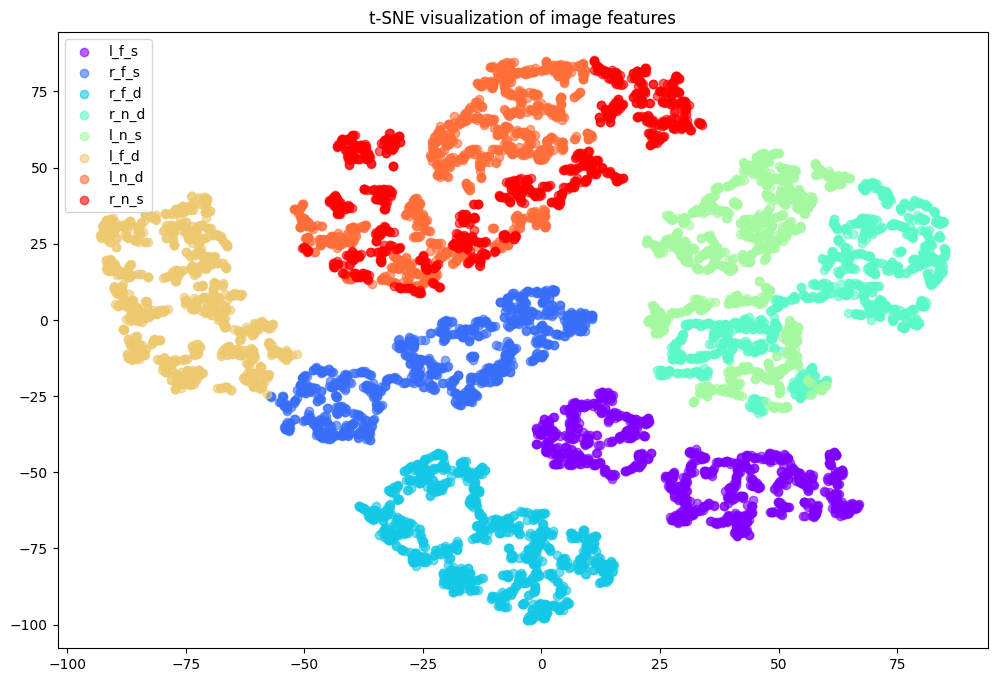

In [5]:
# 准备数据
images = []
labels = []

# 遍历所有子文件夹
for class_name in os.listdir(root_dir):
    class_dir = os.path.join(root_dir, class_name)
    if os.path.isdir(class_dir):
        for img_name in tqdm(os.listdir(class_dir)[:1000], desc=f"Processing {class_name}"):
            img_path = os.path.join(class_dir, img_name)
            try:
                image = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
                images.append(image)
                labels.append(class_name)
            except Exception as e:
                print(f"Error processing {img_path}: {e}")
images = torch.cat(images)
with torch.no_grad():
    features = model.encode_image(images).cpu().numpy()

# 使用t-SNE进行降维
tsne = TSNE(n_components=2, random_state=42)
reduced_features = tsne.fit_transform(features)

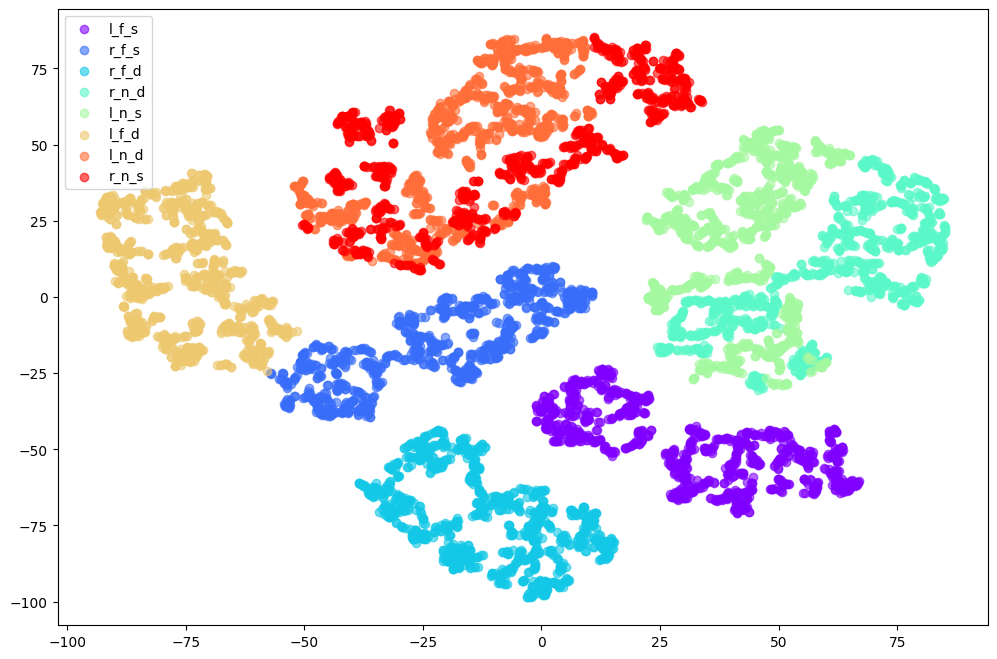

In [7]:
# 绘制散点图
plt.figure(figsize=(12, 8))
colors = plt.cm.rainbow(np.linspace(0, 1, len(set(labels))))
color_dict = dict(zip(set(labels), colors))

for label in set(labels):
    mask = np.array(labels) == label
    plt.scatter(reduced_features[mask, 0], reduced_features[mask, 1], 
                c=[color_dict[label]], label=label, alpha=0.6)

plt.legend()
# plt.title("t-SNE visualization of image features")
# plt.savefig('tsne_visualization.png')
plt.show()

### Vis

[('l', 'f', 'd'), ('l', 'f', 's'), ('l', 'n', 'd'), ('l', 'n', 's')]


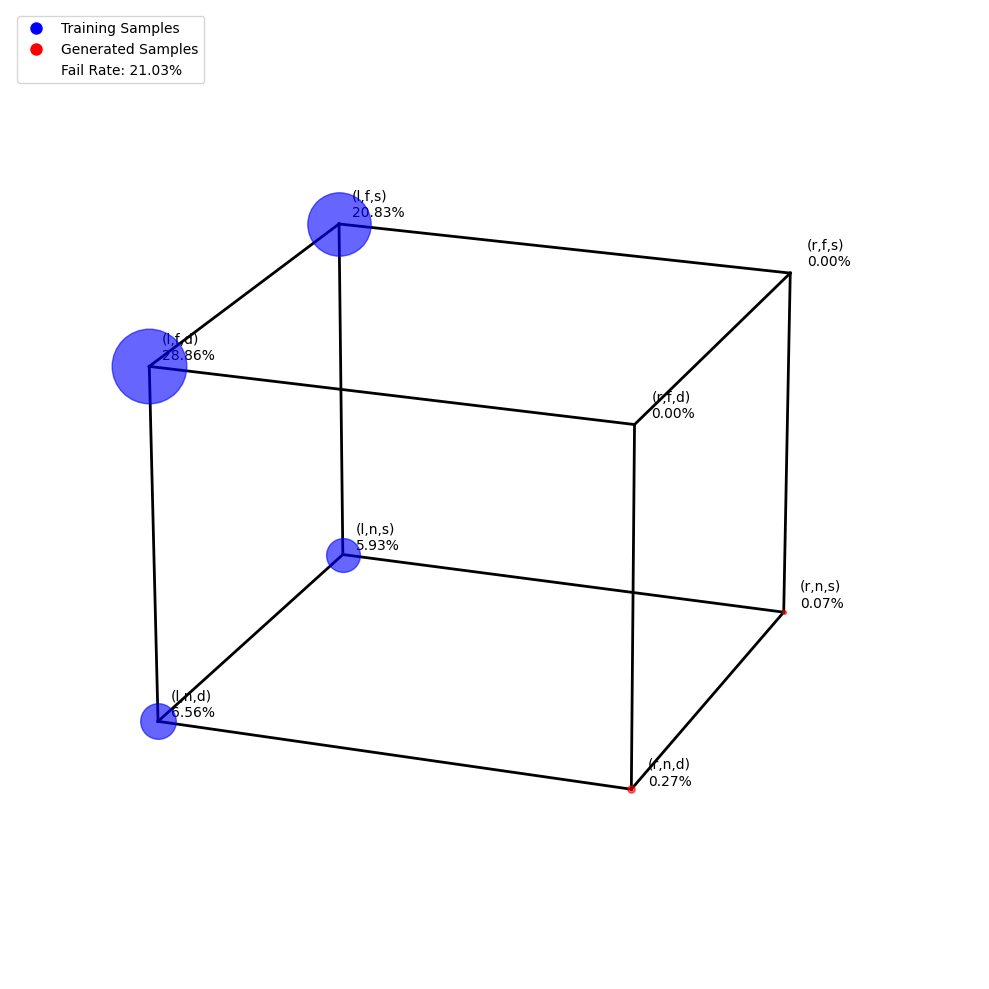

In [31]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import os

# 读取文件内容
file_path = '/cpfs01/user/hanyujin/causal-dm/results/sunshadoweight_lfd_lfs_lnd_lns_v2/vis/1733229172.4379218/analysis_results.txt'
percentages = {}
# 从文件路径中提取蓝色三元组
path_parts = file_path.split('/')
relevant_part = next(part for part in path_parts if part.startswith('sunshadoweight_'))
blue_triples = relevant_part.split('_')[1:-1]  # 去掉 'sunshadoweight_' 和 'v2'
blue_triples = [tuple(triple) for triple in blue_triples]

# 将三元组转换为正确的格式
blue_triples = [tuple(t) for t in blue_triples]

print(blue_triples)  # 用于调试

with open(file_path, 'r') as file:
    content = file.read()
    start = content.index('Label percentages:')
    end = content.index('Number of images in each category:')
    data_section = content[start:end].strip().split('\n')[1:]  # 跳过 "Label percentages:" 行
    
    for line in data_section:
        key, value = line.split(':')
        key = key.strip()
        if key == 'fail':
            percentages[key] = float(value.strip().rstrip('%'))
        else:
            key = eval(key)
            percentages[key] = float(value.strip().rstrip('%'))

# 创建图形
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

# 定义立方体的顶点（按照草稿重新排列）
vertices = np.array([
    [1, 0, 1],  # (l,f,d)
    [1, 1, 1],  # (r,f,d)
    [1, 0, 0],  # (l,n,d)
    [1, 1, 0],  # (r,n,d)
    [0, 0, 1],  # (l,f,s)
    [0, 1, 1],  # (r,f,s)
    [0, 0, 0],  # (l,n,s)
    [0, 1, 0],  # (r,n,s)
])

# 定义立方体的边
edges = [
    [0, 1], [0, 2], [0, 4],
    [1, 3], [1, 5],
    [2, 3], [2, 6],
    [3, 7],
    [4, 5], [4, 6],
    [5, 7],
    [6, 7]
]

# 绘制立方体
for edge in edges:
    ax.plot3D(*vertices[edge].T, color='black', linewidth=2)

# 定义顶点对应的键和标签（按照草稿重新排列）
vertex_keys = [
    ('l', 'f', 'd'), ('r', 'f', 'd'), ('l', 'n', 'd'), ('r', 'n', 'd'),
    ('l', 'f', 's'), ('r', 'f', 's'), ('l', 'n', 's'), ('r', 'n', 's')
]
vertex_labels = [
    '(l,f,d)', '(r,f,d)', '(l,n,d)', '(r,n,d)',
    '(l,f,s)', '(r,f,s)', '(l,n,s)', '(r,n,s)'
]

# 绘制球体和添加标签
for i, (key, label) in enumerate(zip(vertex_keys, vertex_labels)):
    x, y, z = vertices[i][:3]
    if key in percentages:
        color = 'blue' if key in blue_triples else 'red'
        size = percentages[key] * 100  # 增大球体大小以便可见
        ax.scatter(x, y, z, c=color, s=size, alpha=0.6)
    # 调整文本位置以避免被球体覆盖
    text_offset = 0.05
    ax.text(x + text_offset, y + text_offset, z + text_offset, 
            f'{label}\n{percentages.get(key, 0):.2f}%', fontsize=10)

# 移除坐标轴
ax.set_axis_off()

# 设置视角
ax.view_init(elev=20, azim=20)

# 调整图形范围
ax.set_xlim(0, 1.2)
ax.set_ylim(0, 1.2)
ax.set_zlim(0, 1.2)

# 设置背景透明
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

# 添加图例
blue_patch = plt.Line2D([0], [0], marker='o', color='w', label='Training Samples',
                        markerfacecolor='blue', markersize=10)
red_patch = plt.Line2D([0], [0], marker='o', color='w', label='Generated Samples',
                        markerfacecolor='red', markersize=10)
fail_patch = plt.Line2D([0], [0], marker='', color='w', 
                        label=f'Fail Rate: {percentages["fail"]:.2f}%')

legend = plt.legend(handles=[blue_patch, red_patch, fail_patch], loc='upper left', 
                    bbox_to_anchor=(0, 1), fontsize=10)

plt.tight_layout()
plt.show()

[('l', 'f', 'd'), ('l', 'n', 's'), ('l', 'n', 'd'), ('r', 'n', 'd')]


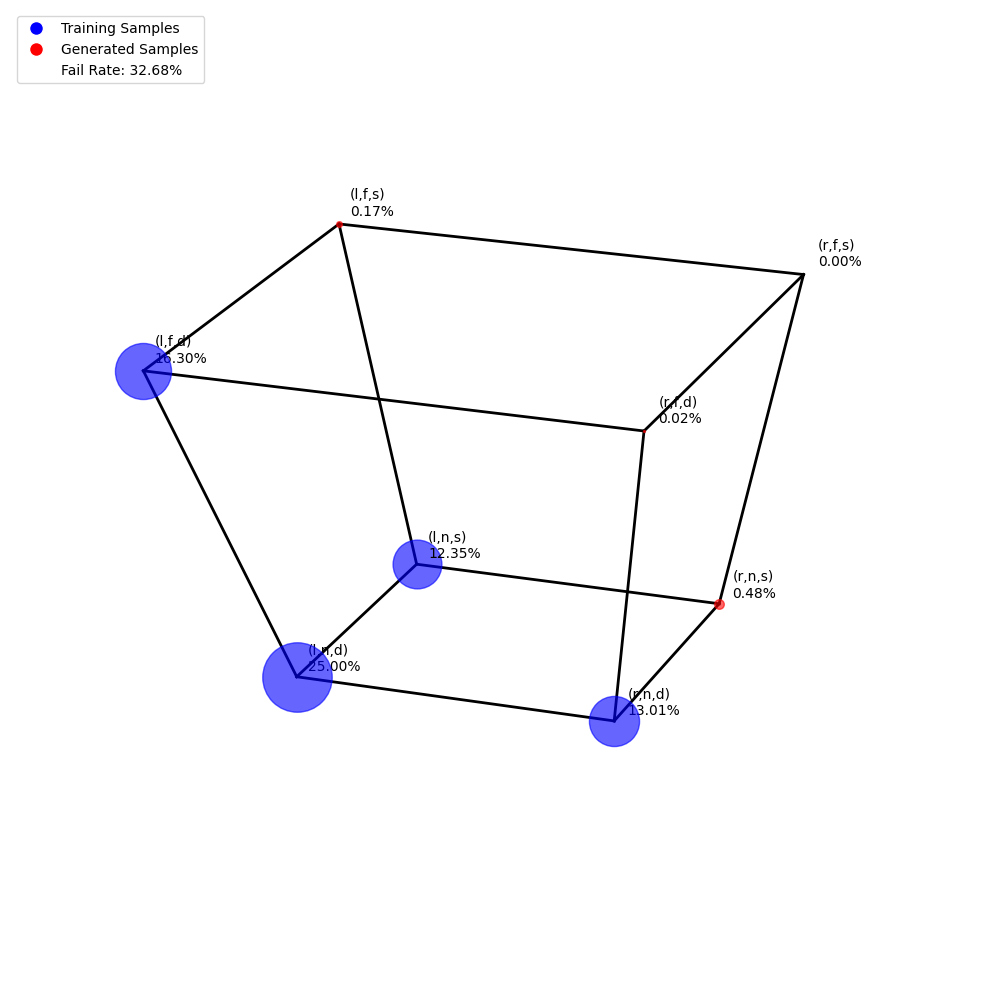

In [83]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import os

# 读取文件内容
file_path = '/cpfs01/user/hanyujin/causal-dm/results/sunshadoweight_lfd_lns_lnd_rnd_v2/vis/1731248020.441068/analysis_results.txt'
percentages = {}

# 从文件路径中提取蓝色三元组
path_parts = file_path.split('/')
relevant_part = next(part for part in path_parts if part.startswith('sunshadoweight_'))
blue_triples = relevant_part.split('_')[1:-1]  # 去掉 'sunshadoweight_' 和 'v2'
blue_triples = [tuple(t) for t in blue_triples]

print(blue_triples)  # 用于调试

with open(file_path, 'r') as file:
    content = file.read()
    start = content.index('Label percentages:')
    end = content.index('Number of images in each category:')
    data_section = content[start:end].strip().split('\n')[1:]  # 跳过 "Label percentages:" 行
    
    for line in data_section:
        key, value = line.split(':')
        key = key.strip()
        if key == 'fail':
            percentages[key] = float(value.strip().rstrip('%'))
        else:
            key = eval(key)
            percentages[key] = float(value.strip().rstrip('%'))

# 创建图形
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

# 定义台体的顶点（远端面大，近端面小）
vertices = np.array([
    [1.2, 0, 1],    # (l,f,d)
    [1.2, 1.2, 1],  # (r,f,d)
    [0.8, 0.2, 0],  # (l,n,d)
    [0.8, 1, 0],    # (r,n,d)
    [0, 0, 1],      # (l,f,s)
    [0, 1.2, 1],    # (r,f,s)
    [0, 0.2, 0],    # (l,n,s)
    [0, 1, 0],      # (r,n,s)
])

# 定义台体的边
edges = [
    [0, 1], [0, 2], [0, 4],
    [1, 3], [1, 5],
    [2, 3], [2, 6],
    [3, 7],
    [4, 5], [4, 6],
    [5, 7],
    [6, 7]
]

# 绘制台体
for edge in edges:
    ax.plot3D(*vertices[edge].T, color='black', linewidth=2)

# 定义顶点对应的键和标签
vertex_keys = [
    ('l', 'f', 'd'), ('r', 'f', 'd'), ('l', 'n', 'd'), ('r', 'n', 'd'),
    ('l', 'f', 's'), ('r', 'f', 's'), ('l', 'n', 's'), ('r', 'n', 's')
]
vertex_labels = [
    '(l,f,d)', '(r,f,d)', '(l,n,d)', '(r,n,d)',
    '(l,f,s)', '(r,f,s)', '(l,n,s)', '(r,n,s)'
]

# 绘制球体和添加标签
for i, (key, label) in enumerate(zip(vertex_keys, vertex_labels)):
    x, y, z = vertices[i][:3]
    if key in percentages:
        color = 'blue' if key in blue_triples else 'red'
        size = percentages[key] * 100  # 增大球体大小以便可见
        ax.scatter(x, y, z, c=color, s=size, alpha=0.6)
    # 调整文本位置以避免被球体覆盖
    text_offset = 0.05
    ax.text(x + text_offset, y + text_offset, z + text_offset, 
            f'{label}\n{percentages.get(key, 0):.2f}%', fontsize=10)

# 移除坐标轴
ax.set_axis_off()

# 设置视角
ax.view_init(elev=20, azim=20)

# 调整图形范围
ax.set_xlim(0, 1.4)
ax.set_ylim(0, 1.4)
ax.set_zlim(0, 1.2)

# 设置背景透明
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

# 添加图例
blue_patch = plt.Line2D([0], [0], marker='o', color='w', label='Training Samples',
                        markerfacecolor='blue', markersize=10)
red_patch = plt.Line2D([0], [0], marker='o', color='w', label='Generated Samples',
                        markerfacecolor='red', markersize=10)
fail_patch = plt.Line2D([0], [0], marker='', color='w', 
                        label=f'Fail Rate: {percentages["fail"]:.2f}%')

legend = plt.legend(handles=[blue_patch, red_patch, fail_patch], loc='upper left', 
                    bbox_to_anchor=(0, 1), fontsize=10)

plt.tight_layout()
plt.show()

#### Vis

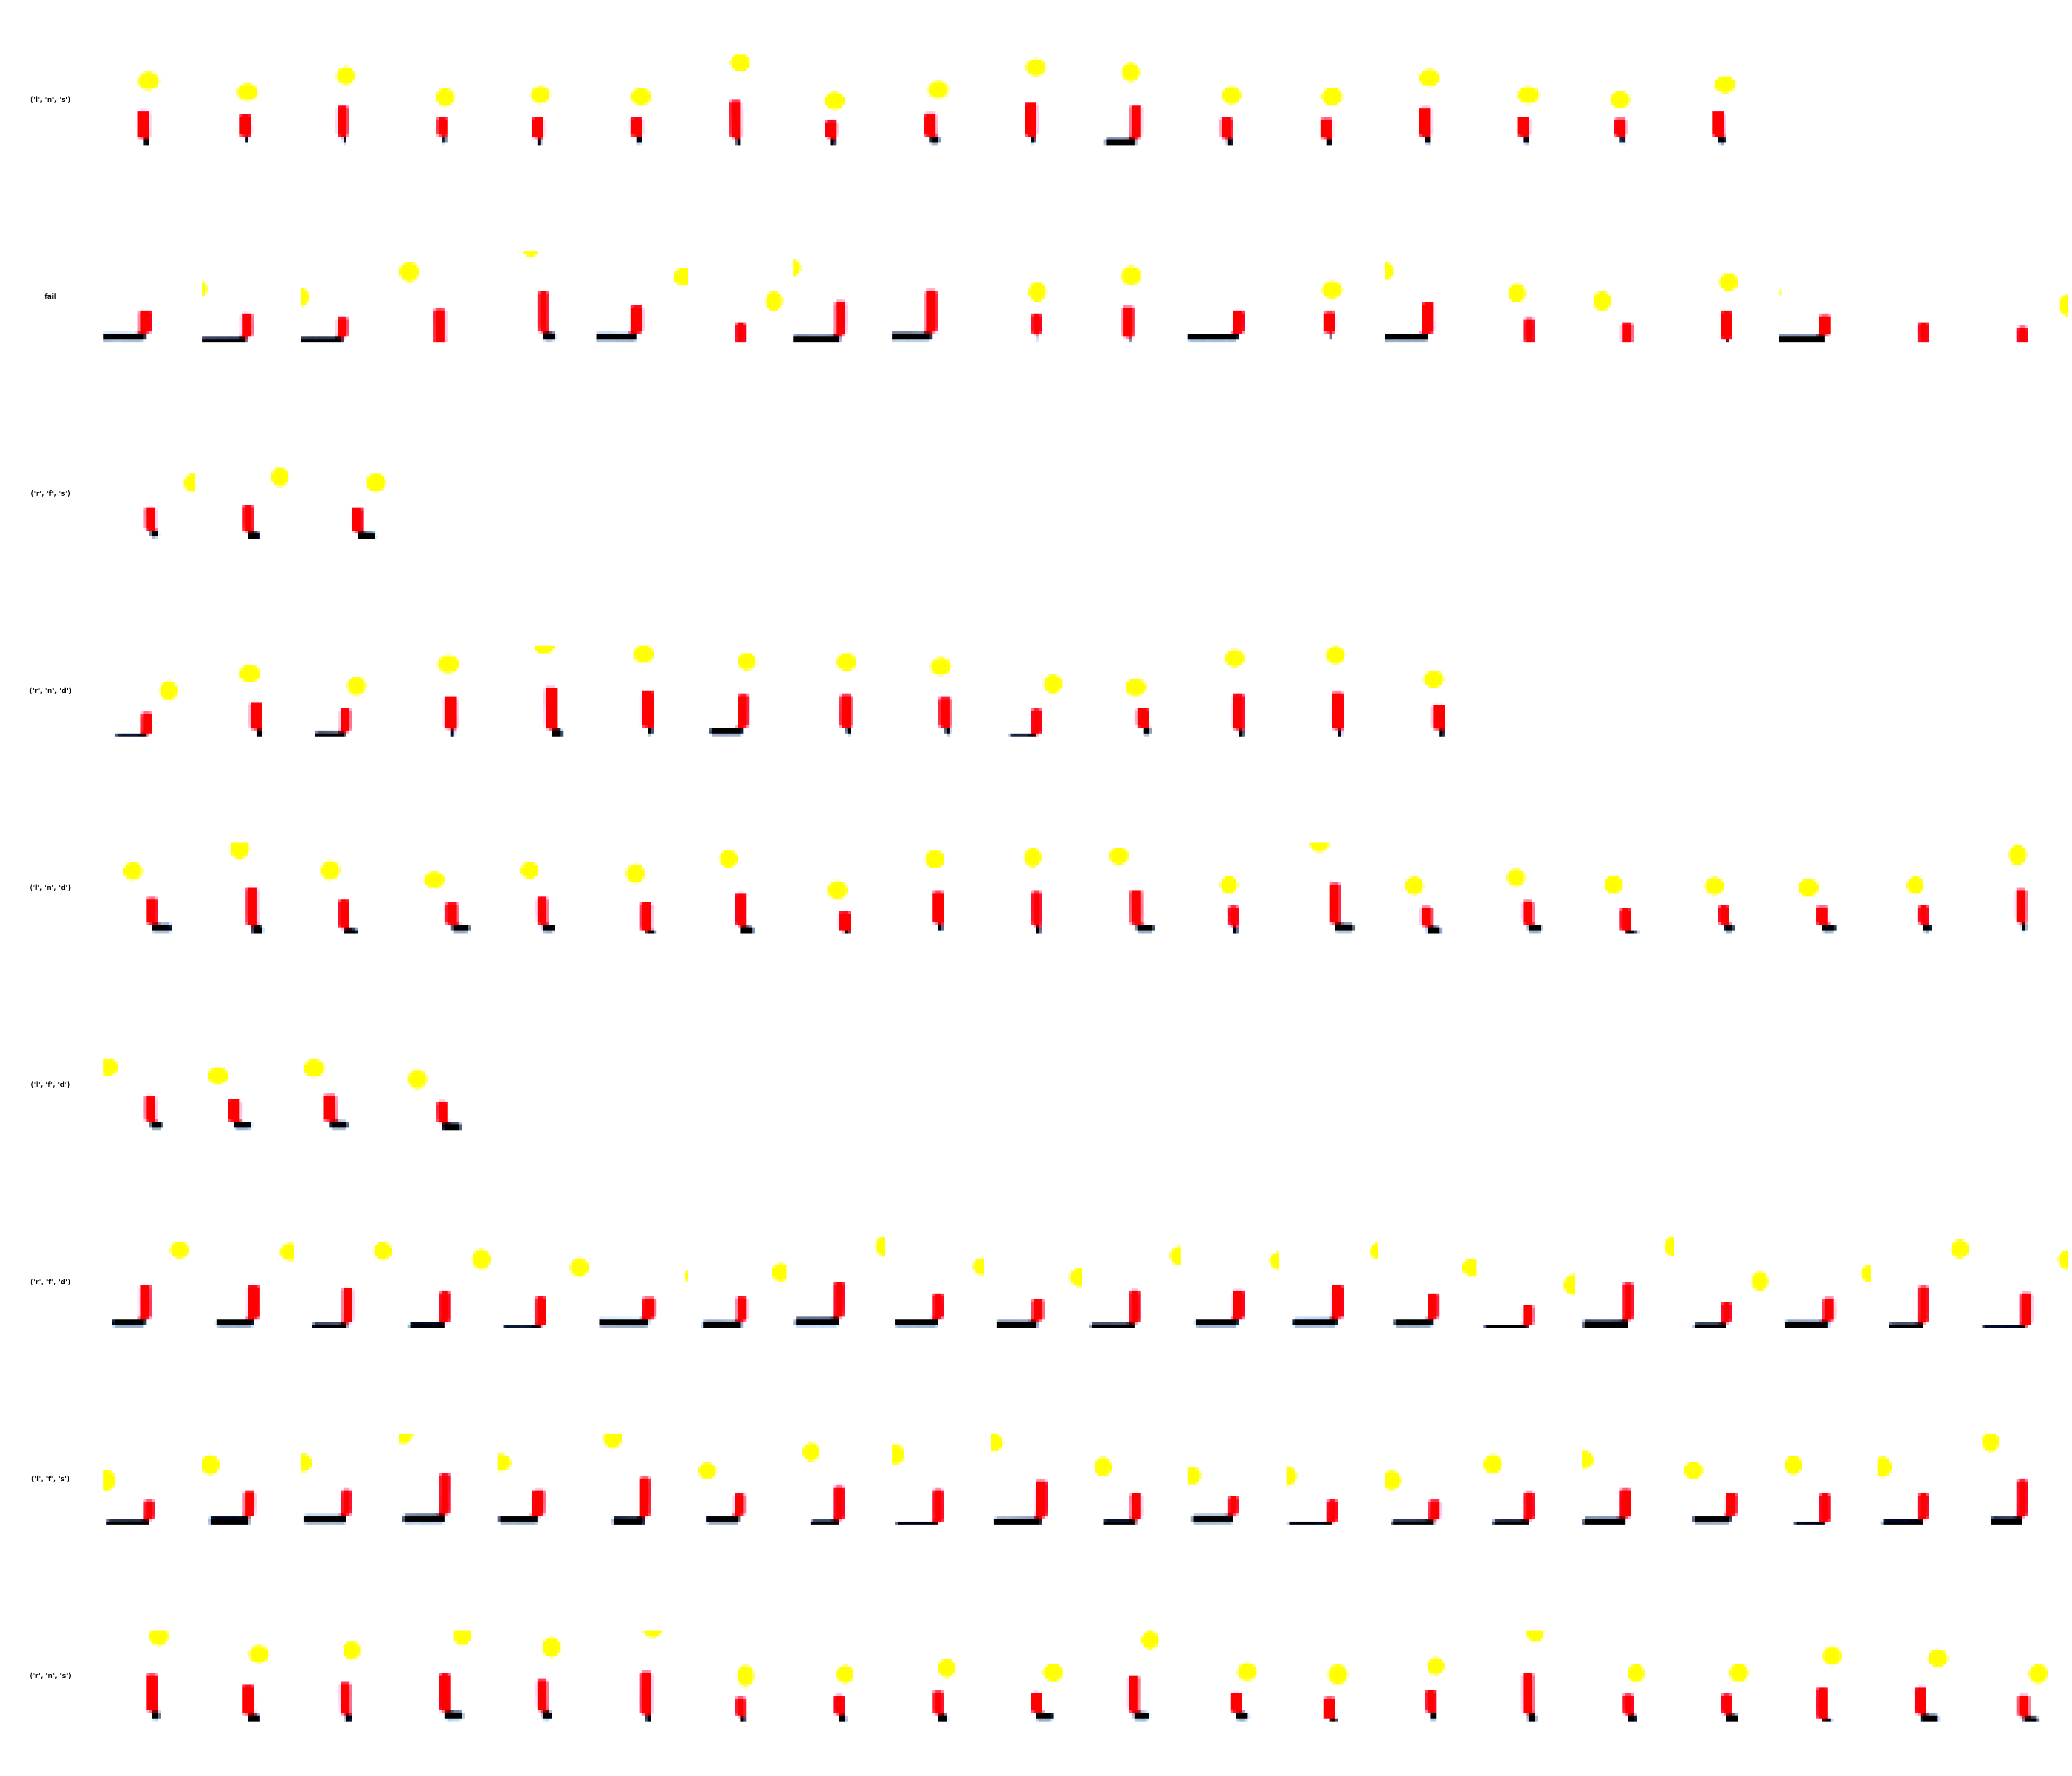

In [7]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# 定义文件路径
base_directory = "/cpfs01/user/hanyujin/causal-dm/results/sunshadoweight_lfs_rfd_lnd_rns_v2/vis/1731251759.8853343"

def get_image_ids(txt_file):
    with open(txt_file, 'r') as f:
        return [line.strip() for line in f.readlines()]

def visualize_images(categories):
    num_categories = len(categories)
    fig, axs = plt.subplots(num_categories, 21, figsize=(42, 4 * num_categories))  # 增加一列用于标签
    
    for i, (category, image_ids) in enumerate(categories.items()):
        # 添加类别标签
        axs[i, 0].text(0.5, 0.5, category, ha='center', va='center', rotation=0, fontsize=10, fontweight='bold')
        axs[i, 0].axis('off')
        
        for j in range(20):
            if j < len(image_ids):
                img_id = image_ids[j]
                img_path = os.path.join(base_directory, img_id)
                if os.path.exists(img_path):
                    img = Image.open(img_path)
                    axs[i, j+1].imshow(img)
                else:
                    axs[i, j+1].text(0.5, 0.5, "Not found", ha='center', va='center')
            axs[i, j+1].axis('off')

    plt.tight_layout()
    # plt.savefig(os.path.join(base_directory, "category_visualization.png"), dpi=300, bbox_inches='tight')
    plt.show()

# 获取所有txt文件
txt_files = [f for f in os.listdir(base_directory) if f.endswith('_files.txt')]

# 从每个txt文件中随机选择最多20张图片
categories = {}
for txt_file in txt_files:
    category = txt_file.split('_files.txt')[0]
    image_ids = get_image_ids(os.path.join(base_directory, txt_file))
    if len(image_ids) > 20:
        image_ids = random.sample(image_ids, 20)
    categories[category] = image_ids

# 可视化
visualize_images(categories)

# print(f"可视化结果已保存到 {os.path.join(base_directory, 'category_visualization.png')}")

# Physical Probe

/tmp/ipykernel_3416682/4041223997.py:43: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  image = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')


Theoretical values: s1=64.00, s2=192.00, l1=96.00, l2=64.00
Detected values: s1=154.00, s2=232.00, l1=115.00, l2=153.00
Theoretical ratio: 4.5000
Detected ratio: 1.1323
Relative error: 74.84%


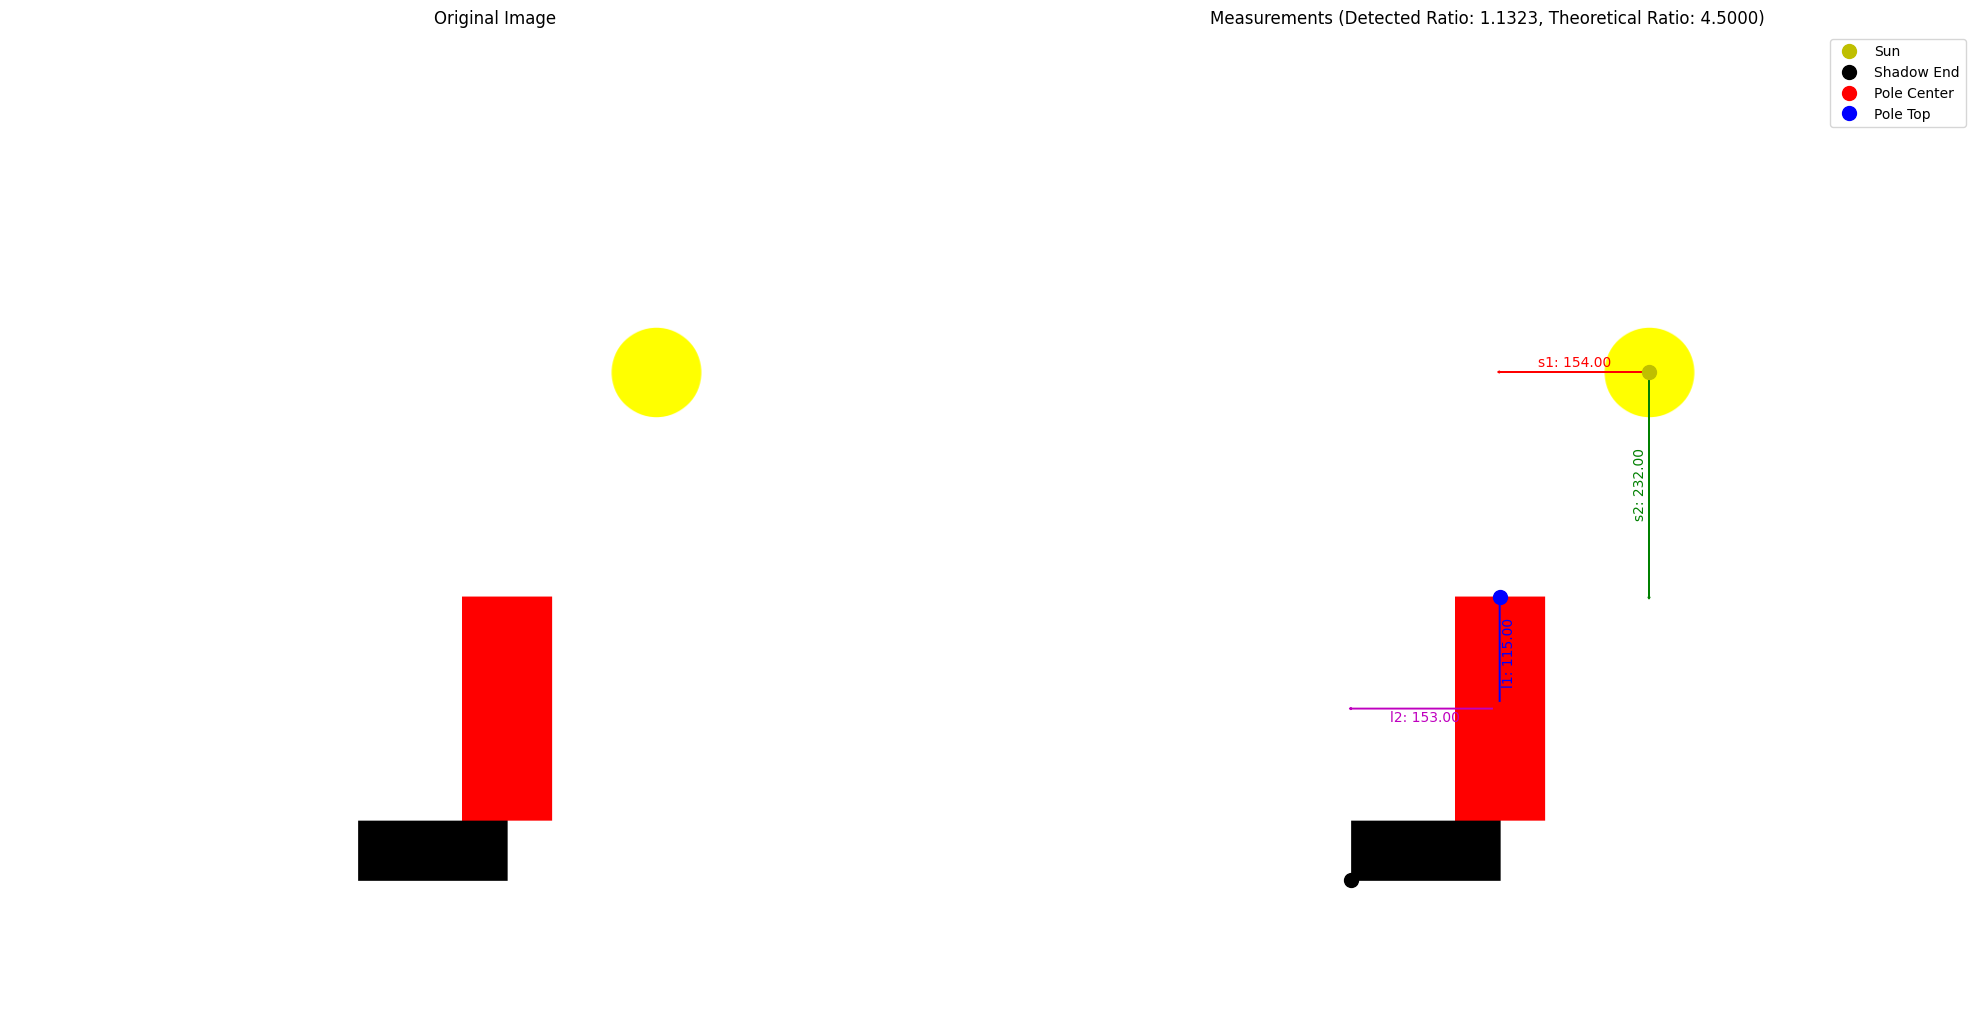

Analysis status: success
Details: Detected ratio: 1.1323, Theoretical ratio: 4.5000, Relative error: 74.84%


In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg

def create_sun_shadow_image(pole_height, sun_distance, image_size=32, is_real=True):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_xlim(0, image_size)
    ax.set_ylim(0, image_size)
    ax.set_aspect('equal')
    ax.axis('off')

    ground_level = image_size * 0.1
    pole_base_x = image_size // 2
    pole_width = image_size * 0.12

    sun_height = np.clip(pole_height * 2, image_size * 0.3, image_size * 0.8)

    shadow_length = pole_height * abs(sun_distance) / (sun_height - pole_height)
    
    shadow_direction = -1 if sun_distance > 0 else 1

    ax.add_patch(plt.Rectangle((pole_base_x, ground_level - image_size * 0.08), 
                               shadow_length * shadow_direction, image_size * 0.08, facecolor='black'))

    ax.add_patch(plt.Rectangle((pole_base_x - pole_width/2, ground_level), 
                               pole_width, pole_height, facecolor='red'))

    sun_radius = image_size * 0.06
    sun_x = pole_base_x + sun_distance
    sun_y = sun_height + ground_level
    ax.add_patch(plt.Circle((sun_x, sun_y), sun_radius, facecolor='yellow'))

    # 计算理论值
    s1 = abs(sun_distance)
    s2 = sun_height
    l1 = pole_height
    l2 = shadow_length

    # 将图形转换为图像
    canvas = FigureCanvasAgg(fig)
    canvas.draw()
    image = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(canvas.get_width_height()[::-1] + (3,))
    plt.close(fig)

    return image, (s1, s2, l1, l2)

def calculate_center_and_end(mask, pole_center):
    y, x = np.nonzero(mask)
    if len(x) == 0 or len(y) == 0:
        return (0, 0), (0, 0)
    left, right = np.min(x), np.max(x)
    top, bottom = np.min(y), np.max(y)
    center_x = (left + right) // 2
    center_y = (top + bottom) // 2
    
    end_x = left if abs(left - pole_center[0]) > abs(right - pole_center[0]) else right
    end_y = bottom
    
    return (center_x, center_y), (end_x, end_y)

def analyze_single_image(image, theoretical_values):
    image_size = image.shape[0]
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    yellow_lower = np.array([20, 100, 100])
    yellow_upper = np.array([30, 255, 255])
    black_lower = np.array([0, 0, 0])
    black_upper = np.array([180, 255, 60])
    red_lower1 = np.array([0, 100, 100])
    red_upper1 = np.array([10, 255, 255])
    red_lower2 = np.array([160, 100, 100])
    red_upper2 = np.array([180, 255, 255])

    yellow_mask = cv2.inRange(hsv, yellow_lower, yellow_upper)
    black_mask = cv2.inRange(hsv, black_lower, black_upper)
    red_mask1 = cv2.inRange(hsv, red_lower1, red_upper1)
    red_mask2 = cv2.inRange(hsv, red_lower2, red_upper2)
    red_mask = cv2.bitwise_or(red_mask1, red_mask2)

    red_y, red_x = np.nonzero(red_mask)
    if len(red_x) == 0 or len(red_y) == 0:
        return "fail", None, "Failed to detect pole"
    red_cx = np.mean(red_x)
    red_cy = np.mean(red_y)
    red_top = np.min(red_y)
    
    (yellow_cx, yellow_cy), _ = calculate_center_and_end(yellow_mask, (red_cx, red_cy))
    (black_cx, black_cy), (shadow_end_x, shadow_end_y) = calculate_center_and_end(black_mask, (red_cx, red_cy))

    s1 = abs(yellow_cx - red_cx)
    s2 = abs(yellow_cy - red_top)
    l1 = red_cy - red_top
    l2 = abs(shadow_end_x - red_cx)

    ratio = (s2 * l1) / (s1 * l2) if s1 != 0 and l2 != 0 else 0

    # 比较理论值和检测值
    s1_theo, s2_theo, l1_theo, l2_theo = theoretical_values
    theo_ratio = (s2_theo * l1_theo) / (s1_theo * l2_theo)
    
    print(f"Theoretical values: s1={s1_theo:.2f}, s2={s2_theo:.2f}, l1={l1_theo:.2f}, l2={l2_theo:.2f}")
    print(f"Detected values: s1={s1:.2f}, s2={s2:.2f}, l1={l1:.2f}, l2={l2:.2f}")
    print(f"Theoretical ratio: {theo_ratio:.4f}")
    print(f"Detected ratio: {ratio:.4f}")
    print(f"Relative error: {abs(theo_ratio - ratio) / theo_ratio * 100:.2f}%")

    # 可视化结果
    plt.figure(figsize=(20, 10))
    
    plt.subplot(121)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(122)
    plt.imshow(image)
    plt.plot(yellow_cx, yellow_cy, 'yo', markersize=10, label='Sun')
    plt.plot(shadow_end_x, shadow_end_y, 'ko', markersize=10, label='Shadow End')
    plt.plot(red_cx, red_cy, 'ro', markersize=10, label='Pole Center')
    plt.plot(red_cx, red_top, 'bo', markersize=10, label='Pole Top')
    
    plt.arrow(yellow_cx, yellow_cy, red_cx - yellow_cx, 0, color='r', width=0.5, head_width=2, head_length=2)
    plt.text((yellow_cx + red_cx) / 2, yellow_cy - 2, f's1: {s1:.2f}', color='r', ha='center', va='bottom')
    
    plt.arrow(yellow_cx, yellow_cy, 0, red_top - yellow_cy, color='g', width=0.5, head_width=2, head_length=2)
    plt.text(yellow_cx - 2, (yellow_cy + red_top) / 2, f's2: {s2:.2f}', color='g', ha='right', va='center', rotation=90)
    
    plt.arrow(red_cx, red_cy, 0, red_top - red_cy, color='b', width=0.5, head_width=2, head_length=2)
    plt.text(red_cx + 2, (red_cy + red_top) / 2, f'l1: {l1:.2f}', color='b', ha='left', va='center', rotation=90)
    
    plt.arrow(red_cx, red_cy, shadow_end_x - red_cx, 0, color='m', width=0.5, head_width=2, head_length=2)
    plt.text((red_cx + shadow_end_x) / 2, red_cy + 2, f'l2: {l2:.2f}', color='m', ha='center', va='top')
    
    plt.title(f"Measurements (Detected Ratio: {ratio:.4f}, Theoretical Ratio: {theo_ratio:.4f})")
    plt.legend()
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    return "success", ratio, f"Detected ratio: {ratio:.4f}, Theoretical ratio: {theo_ratio:.4f}, Relative error: {abs(theo_ratio - ratio) / theo_ratio * 100:.2f}%"

# 主程序
image_size = 320  # 增加图像大小以提高精度
pole_height = image_size * 0.3
sun_distance = image_size * 0.2

image, theoretical_values = create_sun_shadow_image(pole_height, sun_distance, image_size)
status, ratio, details = analyze_single_image(image, theoretical_values)

print(f"Analysis status: {status}")
print(f"Details: {details}")

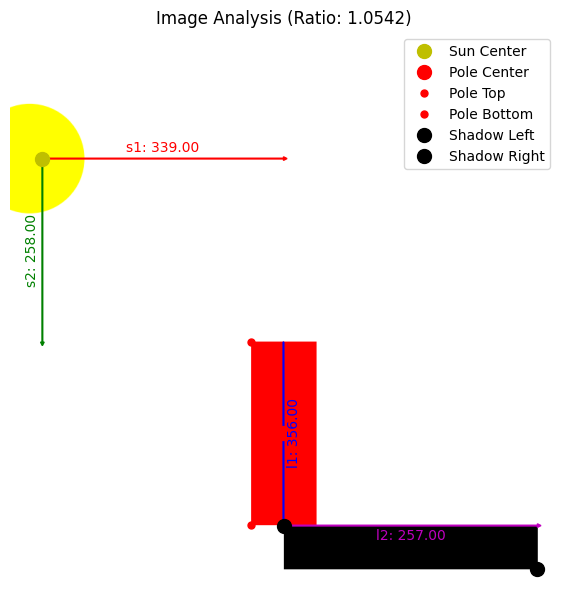

Analysis status: success
Ratio: 1.0542
Details: s1: 339.00, s2: 258.00, l1: 356.00, l2: 257.00, Ratio: 1.0542


In [24]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def analyze_image(image_path):
    # 读取图像
    img = cv2.imread(image_path)
    if img is None:
        return "fail", None, "Image could not be read"

    # 转换为RGB（用于显示）和HSV颜色空间
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # 定义颜色范围
    yellow_lower = np.array([20, 100, 100])
    yellow_upper = np.array([30, 255, 255])
    black_lower = np.array([0, 0, 0])
    black_upper = np.array([180, 255, 60])
    red_lower1 = np.array([0, 100, 100])
    red_upper1 = np.array([10, 255, 255])
    red_lower2 = np.array([160, 100, 100])
    red_upper2 = np.array([180, 255, 255])

    # 创建掩码
    yellow_mask = cv2.inRange(hsv, yellow_lower, yellow_upper)
    black_mask = cv2.inRange(hsv, black_lower, black_upper)
    red_mask1 = cv2.inRange(hsv, red_lower1, red_upper1)
    red_mask2 = cv2.inRange(hsv, red_lower2, red_upper2)
    red_mask = cv2.bitwise_or(red_mask1, red_mask2)

    # 找到太阳、影子和杆子的轮廓
    yellow_contours, _ = cv2.findContours(yellow_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    black_contours, _ = cv2.findContours(black_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    red_contours, _ = cv2.findContours(red_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not yellow_contours or not black_contours or not red_contours:
        return "fail", None, "Failed to detect all elements"

    # 获取太阳的中心
    sun_contour = max(yellow_contours, key=cv2.contourArea)
    sun_moments = cv2.moments(sun_contour)
    sun_cx = int(sun_moments['m10'] / sun_moments['m00'])
    sun_cy = int(sun_moments['m01'] / sun_moments['m00'])

    # 获取杆子的中心、顶部和底部
    pole_contour = max(red_contours, key=cv2.contourArea)
    pole_moments = cv2.moments(pole_contour)
    pole_cx = int(pole_moments['m10'] / pole_moments['m00'])
    pole_cy = int(pole_moments['m01'] / pole_moments['m00'])
    pole_top = tuple(pole_contour[pole_contour[:, :, 1].argmin()][0])
    pole_bottom = tuple(pole_contour[pole_contour[:, :, 1].argmax()][0])

    # 获取影子的端点
    shadow_contour = max(black_contours, key=cv2.contourArea)
    shadow_left = tuple(shadow_contour[shadow_contour[:, :, 0].argmin()][0])
    shadow_right = tuple(shadow_contour[shadow_contour[:, :, 0].argmax()][0])

    # 计算 s1, s2, l1, l2
    s1 = abs(sun_cx - pole_cx)  # 使用杆子的中心
    s2 = abs(sun_cy - pole_top[1])
    l2 = abs(pole_bottom[1] - pole_top[1])  # 不包括影子的宽度
    l1 = abs(shadow_right[0] - shadow_left[0])

    # 计算比率
    ratio = (s2 * l1) / (s1 * l2) if s1 != 0 and l2 != 0 else 0

    # 可视化结果
    plt.figure(figsize=(12, 6))
    plt.imshow(img_rgb)
    plt.plot(sun_cx, sun_cy, 'yo', markersize=10, label='Sun Center')
    plt.plot(pole_cx, pole_cy, 'ro', markersize=10, label='Pole Center')
    plt.plot(pole_top[0], pole_top[1], 'ro', markersize=5, label='Pole Top')
    plt.plot(pole_bottom[0], pole_bottom[1], 'ro', markersize=5, label='Pole Bottom')
    plt.plot(shadow_left[0], shadow_left[1], 'ko', markersize=10, label='Shadow Left')
    plt.plot(shadow_right[0], shadow_right[1], 'ko', markersize=10, label='Shadow Right')

    plt.arrow(sun_cx, sun_cy, pole_cx - sun_cx, 0, color='r', width=1, head_width=5, head_length=5)
    plt.text((sun_cx + pole_cx) / 2, sun_cy - 5, f's1: {s1:.2f}', color='r', ha='center', va='bottom')

    plt.arrow(sun_cx, sun_cy, 0, pole_top[1] - sun_cy, color='g', width=1, head_width=5, head_length=5)
    plt.text(sun_cx - 5, (sun_cy + pole_top[1]) / 2, f's2: {s2:.2f}', color='g', ha='right', va='center', rotation=90)

    plt.arrow(pole_cx, pole_top[1], 0, pole_bottom[1] - pole_top[1], color='b', width=1, head_width=5, head_length=5)
    plt.text(pole_cx + 5, (pole_top[1] + pole_bottom[1]) / 2, f'l1: {l1:.2f}', color='b', ha='left', va='center', rotation=90)

    plt.arrow(shadow_left[0], shadow_left[1], shadow_right[0] - shadow_left[0], 0, color='m', width=1, head_width=5, head_length=5)
    plt.text((shadow_left[0] + shadow_right[0]) / 2, shadow_left[1] + 5, f'l2: {l2:.2f}', color='m', ha='center', va='top')

    plt.title(f"Image Analysis (Ratio: {ratio:.4f})")
    plt.legend()
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    return "success", ratio, f"s1: {s1:.2f}, s2: {s2:.2f}, l1: {l1:.2f}, l2: {l2:.2f}, Ratio: {ratio:.4f}"

# 使用示例
image_path = "/cpfs01/user/hanyujin/causal-dm/synthetic_data_eight_v2/l_f_d/109.png"
status, ratio, details = analyze_image(image_path)

print(f"Analysis status: {status}")
if status == "success":
    print(f"Ratio: {ratio:.4f}")
print(f"Details: {details}")

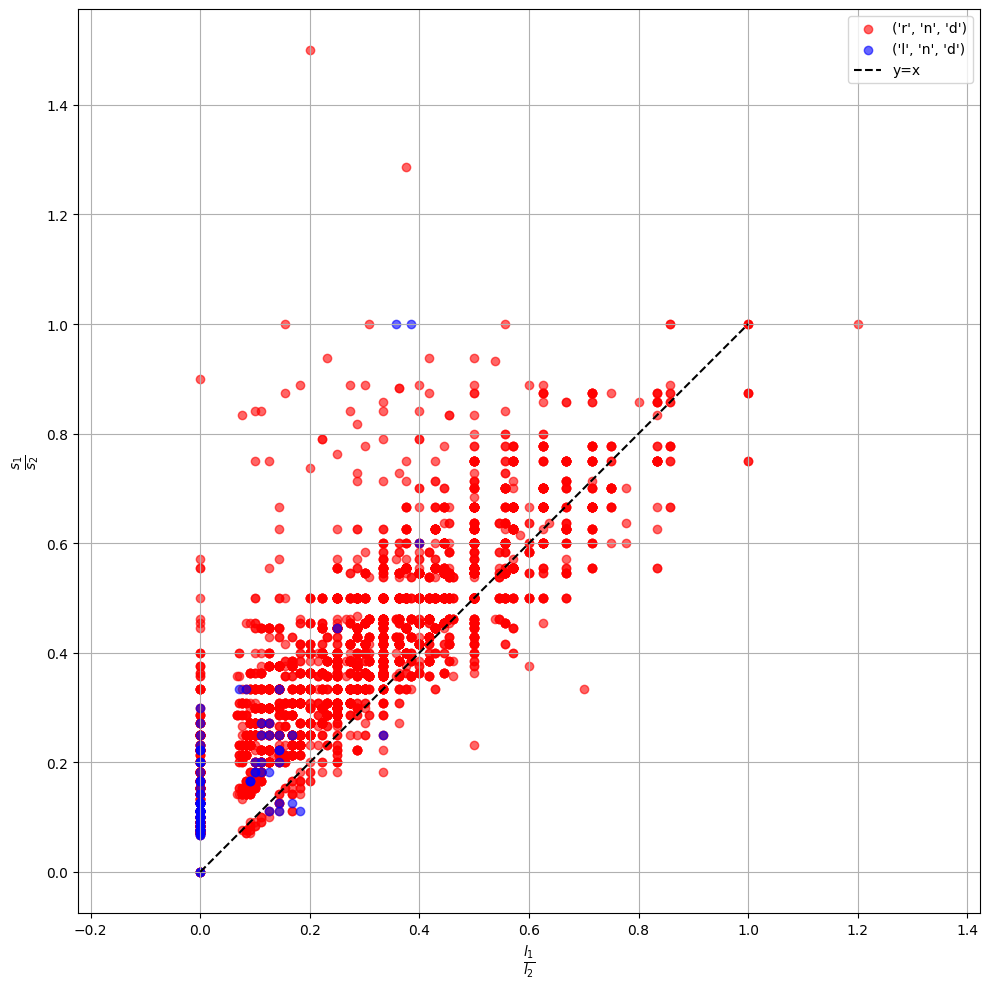

In [31]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

def analyze_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        return None

    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    yellow_lower = np.array([20, 100, 100])
    yellow_upper = np.array([30, 255, 255])
    black_lower = np.array([0, 0, 0])
    black_upper = np.array([180, 255, 60])
    red_lower1 = np.array([0, 100, 100])
    red_upper1 = np.array([10, 255, 255])
    red_lower2 = np.array([160, 100, 100])
    red_upper2 = np.array([180, 255, 255])

    yellow_mask = cv2.inRange(hsv, yellow_lower, yellow_upper)
    black_mask = cv2.inRange(hsv, black_lower, black_upper)
    red_mask1 = cv2.inRange(hsv, red_lower1, red_upper1)
    red_mask2 = cv2.inRange(hsv, red_lower2, red_upper2)
    red_mask = cv2.bitwise_or(red_mask1, red_mask2)

    yellow_contours, _ = cv2.findContours(yellow_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    black_contours, _ = cv2.findContours(black_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    red_contours, _ = cv2.findContours(red_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not yellow_contours or not black_contours or not red_contours:
        return None

    try:
        sun_contour = max(yellow_contours, key=cv2.contourArea)
        sun_moments = cv2.moments(sun_contour)
        sun_cx = int(sun_moments['m10'] / sun_moments['m00']) if sun_moments['m00'] != 0 else 0
        sun_cy = int(sun_moments['m01'] / sun_moments['m00']) if sun_moments['m00'] != 0 else 0

        pole_contour = max(red_contours, key=cv2.contourArea)
        pole_moments = cv2.moments(pole_contour)
        pole_cx = int(pole_moments['m10'] / pole_moments['m00']) if pole_moments['m00'] != 0 else 0
        pole_cy = int(pole_moments['m01'] / pole_moments['m00']) if pole_moments['m00'] != 0 else 0
        pole_top = tuple(pole_contour[pole_contour[:, :, 1].argmin()][0])
        pole_bottom = tuple(pole_contour[pole_contour[:, :, 1].argmax()][0])

        shadow_contour = max(black_contours, key=cv2.contourArea)
        shadow_left = tuple(shadow_contour[shadow_contour[:, :, 0].argmin()][0])
        shadow_right = tuple(shadow_contour[shadow_contour[:, :, 0].argmax()][0])

        s1 = abs(sun_cx - pole_cx)
        s2 = abs(sun_cy - pole_top[1])
        l2 = abs(pole_bottom[1] - pole_top[1])
        l1 = abs(shadow_right[0] - shadow_left[0])

        if l2 == 0 or s2 == 0:
            return None  # 跳过分母为0的情况

        return l1/l2, s1/s2
    except Exception as e:
        print(f"Error processing image {image_path}: {str(e)}")
        return None

# 其他函数保持不变
def process_folder(folder_path):
    txt_files = glob.glob(os.path.join(folder_path, "('*', 'n', 'd')_files.txt"))
    data = {}

    if txt_files:
        for txt_file in txt_files:
            category = os.path.basename(txt_file).split('_')[0]
            with open(txt_file, 'r') as f:
                image_ids = [line.strip() for line in f.readlines()]
            
            data[category] = []
            for image_id in image_ids:
                image_path = os.path.join(folder_path, image_id)
                result = analyze_image(image_path)
                if result:
                    data[category].append(result)
    else:
        # 如果没有txt文件，处理文件夹中所有的png图像
        image_files = glob.glob(os.path.join(folder_path, "*.png"))
        data["all_images"] = []
        for image_path in image_files:
            result = analyze_image(image_path)
            if result:
                data["all_images"].append(result)

    return data

def plot_scatter(data):
    plt.figure(figsize=(10, 10))
    colors = ['r', 'b', 'g', 'c', 'm', 'y', 'k']
    for (category, points), color in zip(data.items(), colors):
        x, y = zip(*points)
        plt.scatter(x, y, c=color, label=category, alpha=0.6)

    plt.plot([0, 1], [0, 1], 'k--', label='y=x')
    plt.xlabel(r'$\frac{l_1}{l_2}$', fontsize=14)
    plt.ylabel(r'$\frac{s_1}{s_2}$', fontsize=14)
    # plt.title('Training Data (l,f,d)')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    # plt.xlim(0, 2)
    # plt.ylim(0, 2)
    plt.tight_layout()
    plt.show()


folder_path = "/cpfs01/user/hanyujin/causal-dm/results/sunshadoweight_rnd_v2/vis/1731421685.0237918"
data = process_folder(folder_path)
plot_scatter(data)

/tmp/ipykernel_3416682/4188928813.py:112: RuntimeWarning: invalid value encountered in scalar divide
  distances = [(abs(point[0][0]/point[0][1] - 1), point) for point in all_points]


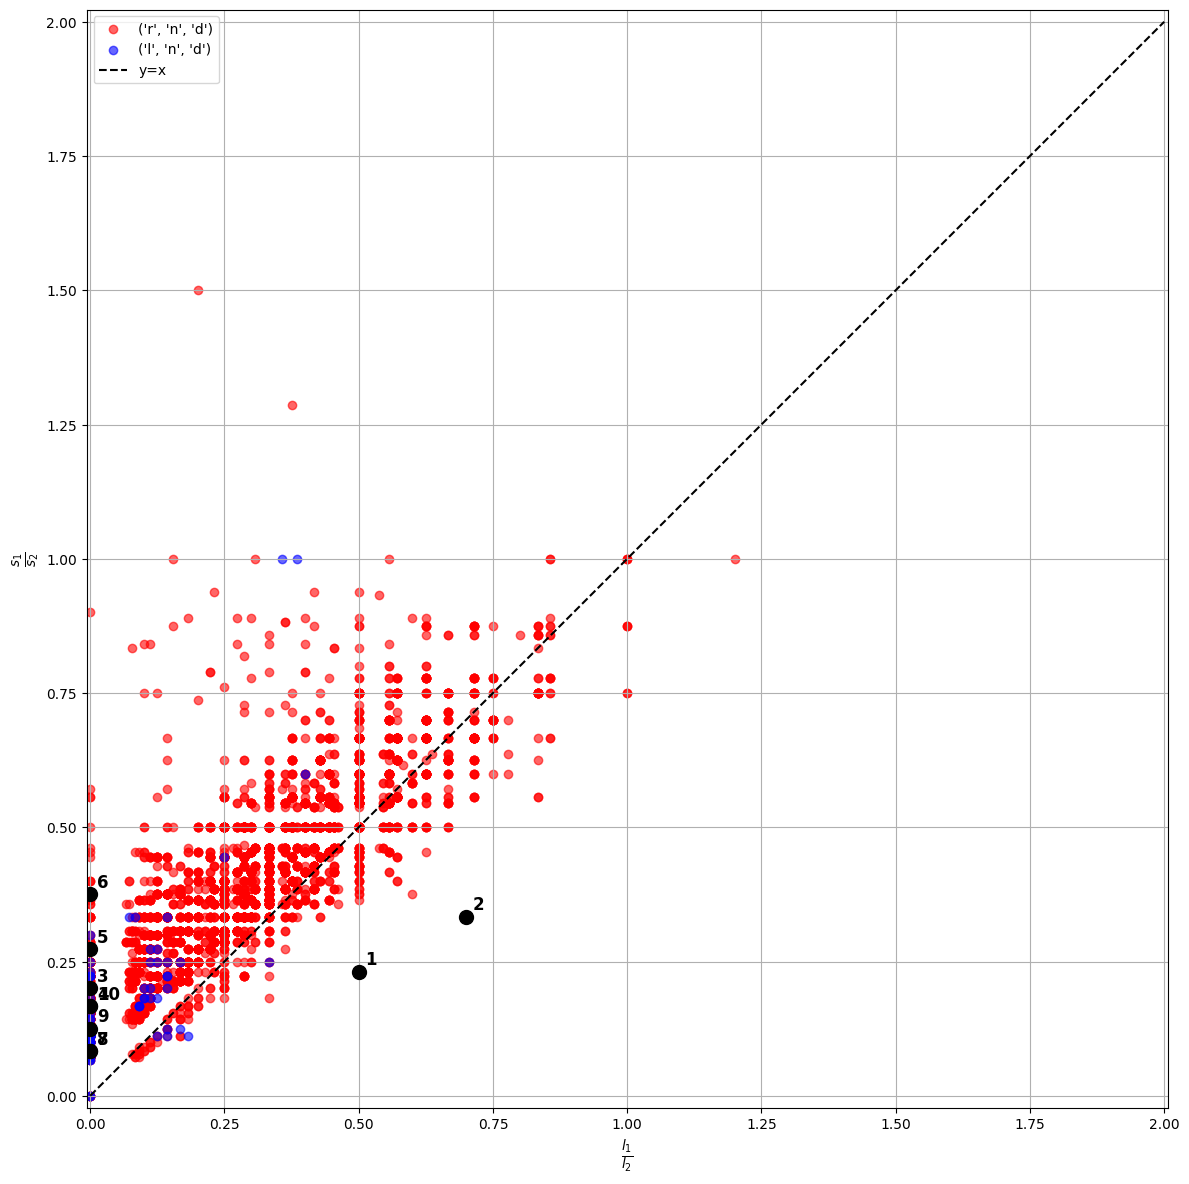

Top 10 points furthest from x/y = 1:
1. Point: (0.5, 0.23076923076923078), Image: sunshadow_1371.png, Distance: 1.1667
2. Point: (0.7, 0.3333333333333333), Image: sunshadow_252.png, Distance: 1.1000
3. Point: (0.0, 0.2), Image: sunshadow_100.png, Distance: 1.0000
4. Point: (0.0, 0.16666666666666666), Image: sunshadow_1000.png, Distance: 1.0000
5. Point: (0.0, 0.2727272727272727), Image: sunshadow_1016.png, Distance: 1.0000
6. Point: (0.0, 0.375), Image: sunshadow_1024.png, Distance: 1.0000
7. Point: (0.0, 0.08333333333333333), Image: sunshadow_1030.png, Distance: 1.0000
8. Point: (0.0, 0.08333333333333333), Image: sunshadow_1054.png, Distance: 1.0000
9. Point: (0.0, 0.125), Image: sunshadow_1055.png, Distance: 1.0000
10. Point: (0.0, 0.16666666666666666), Image: sunshadow_1063.png, Distance: 1.0000


In [33]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from collections import defaultdict

def analyze_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        return None

    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    yellow_lower = np.array([20, 100, 100])
    yellow_upper = np.array([30, 255, 255])
    black_lower = np.array([0, 0, 0])
    black_upper = np.array([180, 255, 60])
    red_lower1 = np.array([0, 100, 100])
    red_upper1 = np.array([10, 255, 255])
    red_lower2 = np.array([160, 100, 100])
    red_upper2 = np.array([180, 255, 255])

    yellow_mask = cv2.inRange(hsv, yellow_lower, yellow_upper)
    black_mask = cv2.inRange(hsv, black_lower, black_upper)
    red_mask1 = cv2.inRange(hsv, red_lower1, red_upper1)
    red_mask2 = cv2.inRange(hsv, red_lower2, red_upper2)
    red_mask = cv2.bitwise_or(red_mask1, red_mask2)

    yellow_contours, _ = cv2.findContours(yellow_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    black_contours, _ = cv2.findContours(black_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    red_contours, _ = cv2.findContours(red_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not yellow_contours or not black_contours or not red_contours:
        return None

    try:
        sun_contour = max(yellow_contours, key=cv2.contourArea)
        sun_moments = cv2.moments(sun_contour)
        sun_cx = int(sun_moments['m10'] / sun_moments['m00']) if sun_moments['m00'] != 0 else 0
        sun_cy = int(sun_moments['m01'] / sun_moments['m00']) if sun_moments['m00'] != 0 else 0

        pole_contour = max(red_contours, key=cv2.contourArea)
        pole_moments = cv2.moments(pole_contour)
        pole_cx = int(pole_moments['m10'] / pole_moments['m00']) if pole_moments['m00'] != 0 else 0
        pole_cy = int(pole_moments['m01'] / pole_moments['m00']) if pole_moments['m00'] != 0 else 0
        pole_top = tuple(pole_contour[pole_contour[:, :, 1].argmin()][0])
        pole_bottom = tuple(pole_contour[pole_contour[:, :, 1].argmax()][0])

        shadow_contour = max(black_contours, key=cv2.contourArea)
        shadow_left = tuple(shadow_contour[shadow_contour[:, :, 0].argmin()][0])
        shadow_right = tuple(shadow_contour[shadow_contour[:, :, 0].argmax()][0])

        s1 = abs(sun_cx - pole_cx)
        s2 = abs(sun_cy - pole_top[1])
        l2 = abs(pole_bottom[1] - pole_top[1])
        l1 = abs(shadow_right[0] - shadow_left[0])

        if l2 == 0 or s2 == 0:
            return None  # 跳过分母为0的情况

        return l1/l2, s1/s2
    except Exception as e:
        print(f"Error processing image {image_path}: {str(e)}")
        return None

def process_folder(folder_path):
    txt_files = glob.glob(os.path.join(folder_path, "('*', 'n', 'd')_files.txt"))
    data = defaultdict(list)

    if txt_files:
        for txt_file in txt_files:
            category = os.path.basename(txt_file).split('_')[0]
            with open(txt_file, 'r') as f:
                image_ids = [line.strip() for line in f.readlines()]
            
            for image_id in image_ids:
                image_path = os.path.join(folder_path, image_id)
                result = analyze_image(image_path)
                if result:
                    data[category].append((result, image_path))
    else:
        # 如果没有txt文件，处理文件夹中所有的png图像
        image_files = glob.glob(os.path.join(folder_path, "*.png"))
        for image_path in image_files:
            result = analyze_image(image_path)
            if result:
                data["all_images"].append((result, image_path))

    return data

def plot_scatter(data):
    plt.figure(figsize=(12, 12))
    colors = ['r', 'b', 'g', 'c', 'm', 'y', 'k']
    all_points = []
    
    for (category, points), color in zip(data.items(), colors):
        x, y = zip(*[p[0] for p in points])
        plt.scatter(x, y, c=color, label=category, alpha=0.6)
        all_points.extend(points)

    plt.plot([0, 2], [0, 2], 'k--', label='y=x')
    plt.xlabel(r'$\frac{l_1}{l_2}$', fontsize=14)
    plt.ylabel(r'$\frac{s_1}{s_2}$', fontsize=14)
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.xlim(0, 2)
    plt.ylim(0, 2)

    # 计算每个点到 x/y=1 的距离
    distances = [(abs(point[0][0]/point[0][1] - 1), point) for point in all_points]
    
    # 排序并获取前10个
    top_10 = sorted(distances, key=lambda x: x[0], reverse=True)[:10]

    # 在散点图上标记这10个点
    for i, (distance, (point, image_path)) in enumerate(top_10, 1):
        plt.annotate(f'{i}', xy=point, xytext=(5, 5), textcoords='offset points', 
                     fontsize=12, color='black', weight='bold')
        plt.scatter(*point, c='black', s=100, zorder=5)

    plt.tight_layout()
    plt.show()

    print("Top 10 points furthest from x/y = 1:")
    for i, (distance, (point, image_path)) in enumerate(top_10, 1):
        print(f"{i}. Point: {point}, Image: {os.path.basename(image_path)}, Distance: {distance:.4f}")
folder_path = "/cpfs01/user/hanyujin/causal-dm/results/sunshadoweight_rnd_v2/vis/1731421685.0237918"
data = process_folder(folder_path)
plot_scatter(data)

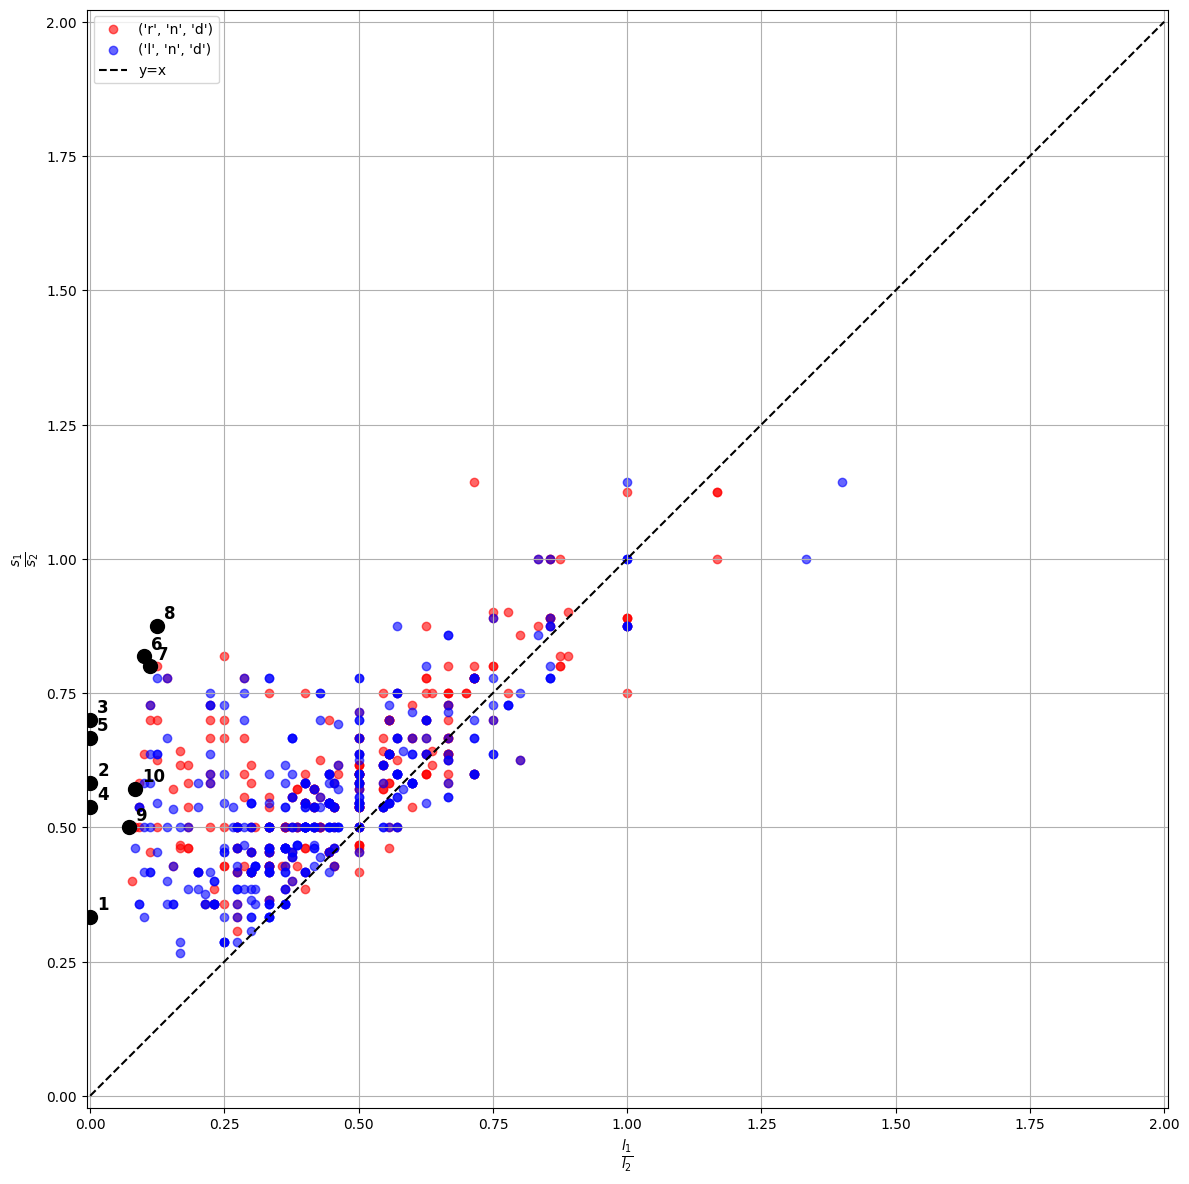

Top 10 points furthest from x/y = 1:
1. Point: (0.0, 0.3333333333333333), Image: sunshadow_1096.png, Distance: 1.0000
2. Point: (0.0, 0.5833333333333334), Image: sunshadow_458.png, Distance: 1.0000
3. Point: (0.0, 0.7), Image: sunshadow_799.png, Distance: 1.0000
4. Point: (0.0, 0.5384615384615384), Image: sunshadow_1527.png, Distance: 1.0000
5. Point: (0.0, 0.6666666666666666), Image: sunshadow_1066.png, Distance: 1.0000
6. Point: (0.1, 0.8181818181818182), Image: sunshadow_4.png, Distance: 0.8778
7. Point: (0.1111111111111111, 0.8), Image: sunshadow_1811.png, Distance: 0.8611
8. Point: (0.125, 0.875), Image: sunshadow_339.png, Distance: 0.8571
9. Point: (0.07142857142857142, 0.5), Image: sunshadow_1184.png, Distance: 0.8571
10. Point: (0.08333333333333333, 0.5714285714285714), Image: sunshadow_1504.png, Distance: 0.8542

Point closest to l1/l2 = 1.4:
Point: (1.4, 1.1428571428571428), Image: sunshadow_632.png


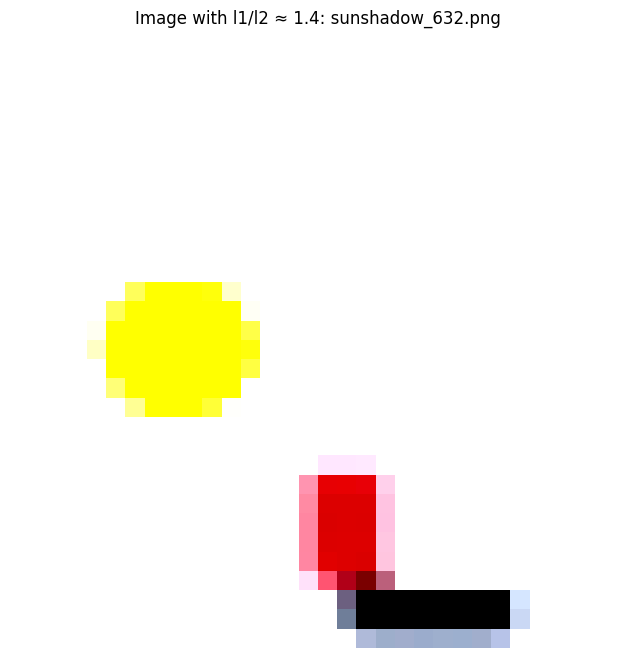

In [111]:
def plot_scatter(data):
    plt.figure(figsize=(12, 12))
    colors = ['r', 'b', 'g', 'c', 'm', 'y', 'k']
    all_points = []
    
    for (category, points), color in zip(data.items(), colors):
        x, y = zip(*[p[0] for p in points])
        plt.scatter(x, y, c=color, label=category, alpha=0.6)
        all_points.extend(points)

    plt.plot([0, 2], [0, 2], 'k--', label='y=x')
    plt.xlabel(r'$\frac{l_1}{l_2}$', fontsize=14)
    plt.ylabel(r'$\frac{s_1}{s_2}$', fontsize=14)
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.xlim(0, 2)
    plt.ylim(0, 2)

    # 计算每个点到 x/y=1 的距离
    distances = [(abs(point[0][0]/point[0][1] - 1), point) for point in all_points]
    
    # 排序并获取前10个
    top_10 = sorted(distances, key=lambda x: x[0], reverse=True)[:10]

    # 在散点图上标记这10个点
    for i, (distance, (point, image_path)) in enumerate(top_10, 1):
        plt.annotate(f'{i}', xy=point, xytext=(5, 5), textcoords='offset points', 
                     fontsize=12, color='black', weight='bold')
        plt.scatter(*point, c='black', s=100, zorder=5)

    plt.tight_layout()
    plt.show()

    print("Top 10 points furthest from x/y = 1:")
    for i, (distance, (point, image_path)) in enumerate(top_10, 1):
        print(f"{i}. Point: {point}, Image: {os.path.basename(image_path)}, Distance: {distance:.4f}")

    # 查找 l1/l2 接近 1.4 的点
    target = 1.4
    closest_point = min(all_points, key=lambda x: abs(x[0][0] - target))
    print(f"\nPoint closest to l1/l2 = 1.4:")
    print(f"Point: {closest_point[0]}, Image: {os.path.basename(closest_point[1])}")

    # 显示对应的图像
    img = cv2.imread(closest_point[1])
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(8, 8))
    plt.imshow(img_rgb)
    plt.title(f"Image with l1/l2 ≈ 1.4: {os.path.basename(closest_point[1])}")
    plt.axis('off')
    plt.show()

folder_path = "/cpfs01/user/hanyujin/causal-dm/results/sunshadoweight_lfd_rfd_lnd_rnd/vis/1731203044.5450642"
data = process_folder(folder_path)
plot_scatter(data)